This document provides a suggested outline for the notebook used for the data challenge. Please make sure you run this notebook before you made a submission, so that you have the code and results.

## Problem definition and task allocations.

In this section, please describe briefly:
- the problems in this project.
- how do you attribute the tasks to the team members.

You can use this Table to allocate the tasks:

| Member | Task | 
| --- | --- |
| Member 1 | Task 1 |
| --- | --- |



## Reading the data

### Read the training data

In [15]:
utility_path = '../'
import sys
sys.path.insert(1, utility_path)

from util import read_all_test_data_from_path
import numpy as np 
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import warnings
%matplotlib inline
from scipy.signal import butter, filtfilt


# Function to design a Butterworth low-pass filter
def butter_lowpass(cutoff, fs, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a


# Function to apply the Butterworth low-pass filter
def lowpass_filter(data, cutoff_freq, sampling_freq, order=5):
    b, a = butter_lowpass(cutoff_freq, sampling_freq, order=order)
    filtered_data = filtfilt(b, a, data)
    return filtered_data


# Set parameters for the low-pass filter
cutoff_frequency = .5  # Adjust as needed
sampling_frequency = 10  

def customized_outlier_removal(df: pd.DataFrame):
    ''' # Description
    Remove outliers from the dataframe based on defined valid ranges. 
    Define a valid range of temperature and voltage. 
    Use ffil function to replace the invalid measurement with the previous value.
    '''
    df['position'] = df['position'].where(df['position'] <= 1000, np.nan)
    df['position'] = df['position'].where(df['position'] >= 0, np.nan)
    df['position'] = df['position'].ffill()
    df['position'] = lowpass_filter(df['position'], cutoff_frequency, sampling_frequency)
    df['position'] = df['position'].rolling(window=10, min_periods=1).mean()
    df['position'] = df['position'].round()

    df['temperature'] = df['temperature'].where(df['temperature'] <= 100, np.nan)
    df['temperature'] = df['temperature'].where(df['temperature'] >= 0, np.nan)
    df['temperature'] = df['temperature'].rolling(window=10, min_periods=1).mean()

    # # Make sure that the difference between the current and previous temperature cannot be too large.
    # # Define your threshold
    # threshold = 10
    # # Shift the 'temperature' column by one row to get the previous temperature
    # prev_tmp = df['temperature'].shift(1)
    # # Calculate the absolute difference between current and previous temperature
    # temp_diff = np.abs(df['temperature'] - prev_tmp)
    # # Set the temperature to NaN where the difference is larger than the threshold
    # df.loc[temp_diff > threshold, 'temperature'] = np.nan
    # df['temperature'] = df['temperature'].ffill()

    df['voltage'] = df['voltage'].where(df['voltage'] >= 6000, np.nan)
    df['voltage'] = df['voltage'].where(df['voltage'] <= 8000, np.nan)
    df['voltage'] = df['voltage'].ffill()
    df['voltage'] = lowpass_filter(df['voltage'], cutoff_frequency, sampling_frequency)
    df['voltage'] = df['voltage'].rolling(window=5, min_periods=1).mean()

def cal_diff(df: pd.DataFrame, n_int: int = 20):
    ''' # Description
    Calculate the difference between the current and previous n data point.
    '''
    # Tranform the features relative to the first data point.
    df['temperature'] = df['temperature'] - df['temperature'].iloc[0]
    df['voltage'] = df['voltage'] - df['voltage'].iloc[0]
    df['position'] = df['position'] - df['position'].iloc[0]

    # Calculate the difference between the current and previous n data point.
    # df['temperature_diff'] = df['temperature'].diff(n_int)
    # df['voltage_diff'] = df['voltage'].diff(n_int)
    # df['position_diff'] = df['position'].diff(n_int)    

def pre_processing(df: pd.DataFrame):
    ''' ### Description
    Preprocess the data:
    - remove outliers
    - add new features about the difference between the current and previous n data point.
    '''
    # Start processing.
    customized_outlier_removal(df)
    cal_diff(df)


In [16]:
# Ignore warnings.
warnings.filterwarnings('ignore')

# Read all the dataset. Change to your dictionary if needed.
base_dictionary = 'dataset/training_data/training_data/'
df_train = read_all_test_data_from_path(base_dictionary, pre_processing, is_plot=False)

### Read the testing data.

In [17]:
# Read all the dataset. Change to your dictionary if needed.
base_dictionary = 'dataset/testing_data/'
df_test = read_all_test_data_from_path(base_dictionary, pre_processing, is_plot=False)

In [18]:
#Train files
not_moving_train = ['20240105_164214', '20240105_165972', '20240320_152031', '20240320_155664','20240325_135213', '20240425_093699', '20240425_094425', '20240426_140055']
pickup_and_place_train = ['20240105_165300', '20240321_122650', '20240325_152902','20240325_155003', '20240426_141190','20240503_163963']
moving_one_motor_train = ['20240426_141532','20240426_141602','20240426_141726','20240426_141938','20240426_141980']
turning_motor_6_train = ['20240503_164435','20240503_164675','20240503_165189' ]
moving_motors_sequentially_train = ['20240320_153841']

moving_motor_mixed_train = moving_one_motor_train + moving_motors_sequentially_train + turning_motor_6_train
#Test files
transfer_goods_test = ["20240527_094865","20240527_100759","20240527_101627"]
not_moving_test = ['20240527_102436','20240527_102919','20240527_103311']
moving_one_motor_test = ['20240527_103690','20240527_104247']

# Motor 6

In [19]:
from utility import extract_selected_feature, prepare_sliding_window, run_cv_one_motor
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

# Define the motor index.
motor_idx = 6

# Specify the test conditions you would like to include in the training.
df_data_experiment = df_train[df_train['test_condition'].isin(['20240425_093699', '20240425_094425', '20240426_140055',
                                                       '20240503_164675', '20240503_165189',
                                                       '20240503_163963', '20240325_155003'])]

# Define the features.
feature_list_all = ['time', 'data_motor_1_position', 'data_motor_1_temperature', 'data_motor_1_voltage',
                    'data_motor_2_position', 'data_motor_2_temperature', 'data_motor_2_voltage',
                    'data_motor_3_position', 'data_motor_3_temperature', 'data_motor_3_voltage',
                    'data_motor_4_position', 'data_motor_4_temperature', 'data_motor_4_voltage',
                    'data_motor_5_position', 'data_motor_5_temperature', 'data_motor_5_voltage',
                    'data_motor_6_position', 'data_motor_6_temperature', 'data_motor_6_voltage']

# Define the classification model.
# Define the steps of the pipeline
steps = [
    ('standardizer', StandardScaler()),  # Step 1: StandardScaler
    ('mdl', LogisticRegression(class_weight="balanced", n_jobs=-1))    
]

# Create the pipeline
pipeline = Pipeline(steps)

# Define hyperparameters to search
param_grid_6 = {
    'mdl__C': [0.1, 0.1, 1, 10]  # Inverse of regularization strength
}

# Initialize GridSearchCV
grid_search_6 = GridSearchCV(estimator=pipeline, param_grid=param_grid_6, scoring='f1', cv=5)

feature_list_motor6 = ['data_motor_1_position', 'data_motor_1_temperature',
                    'data_motor_2_temperature', 'data_motor_2_position',
                    'data_motor_3_position', 'data_motor_3_temperature',
                    'data_motor_4_position', 'data_motor_4_voltage',
                    'data_motor_6_temperature']

# Train the model.
run_cv_one_motor(single_run_result=False, motor_idx=6, df_data=df_data_experiment, mdl=grid_search_6, feature_list=feature_list_motor6, n_fold=5, window_size=20, sample_step=5)

Model for motor 6:
   Accuracy  Precision    Recall  F1 score
0  0.152812   0.087407  0.770328  0.157000
1  0.891443   0.556122  0.567708  0.561856
2  0.530973   0.374829  0.789625  0.508349
3  0.827586   0.827586  1.000000  0.905660
4  0.671504   0.186441  0.051887  0.081181


Mean performance metric and standard error:
Accuracy: 0.6149 +- 0.2939
Precision: 0.4065 +- 0.2962
Recall: 0.6359 +- 0.3606
F1 score: 0.4428 +- 0.3336




,Accuracy,Precision,Recall,F1 score
0,0.152812,0.087407,0.770328,0.157000
1,0.891443,0.556122,0.567708,0.561856
2,0.530973,0.374829,0.789625,0.508349
3,0.827586,0.827586,1.000000,0.905660
4,0.671504,0.186441,0.051887,0.081181


In [20]:
df_tr_x, df_tr_y = extract_selected_feature(df_data_experiment, feature_list_motor6, motor_idx = 6, mdl_type='clf')

grid_search_6.fit(df_tr_x, df_tr_y)
# Get the features.
feature_list_motor6 = feature_list_motor6 + ['test_condition']
df_test_x = df_test[feature_list_motor6]
y_pred_6 = grid_search_6.predict(df_test_x)

# Motor 5

Model for motor 5:

 New run:

training performance, accuracy is: 0.9977689638076351
training performance, precision is: 1.0
training performance, recall: 0.9210526315789473
training performance, F1: 0.958904109589041



 New run:

testing performance, accuracy is: 0.9884587289992696
testing performance, precision is: 0.0
testing performance, recall: 0.0
testing performance, F1: 0.0




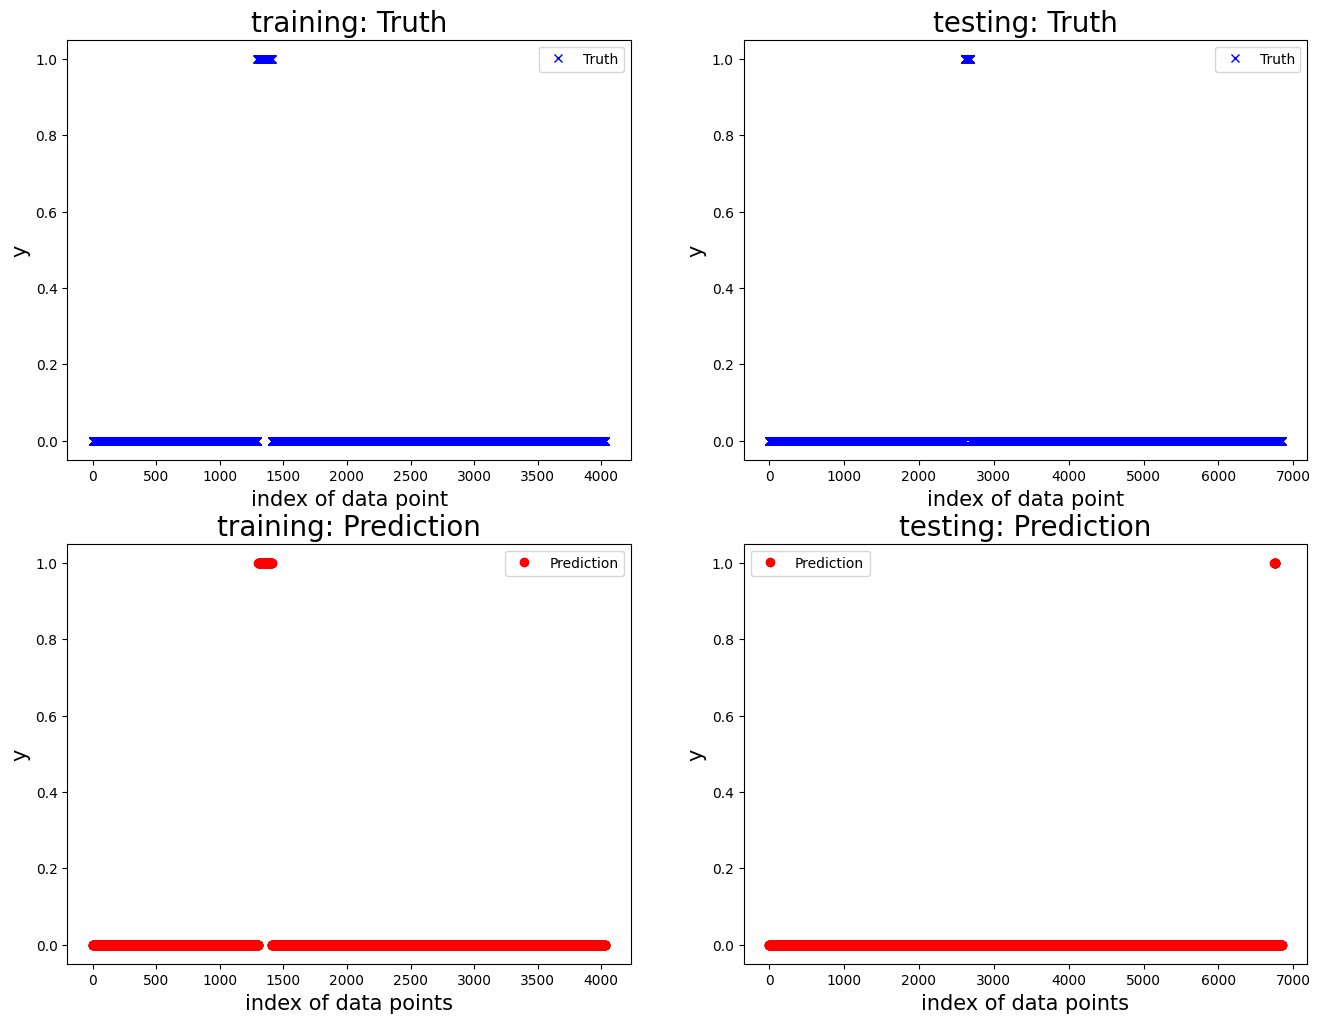


 New run:

training performance, accuracy is: 0.9864705250724793
training performance, precision is: 0.35714285714285715
training performance, recall: 1.0
training performance, F1: 0.5263157894736842



 New run:

testing performance, accuracy is: 0.9272030651340997
testing performance, precision is: 0.0
testing performance, recall: 0.0
testing performance, F1: 0.0




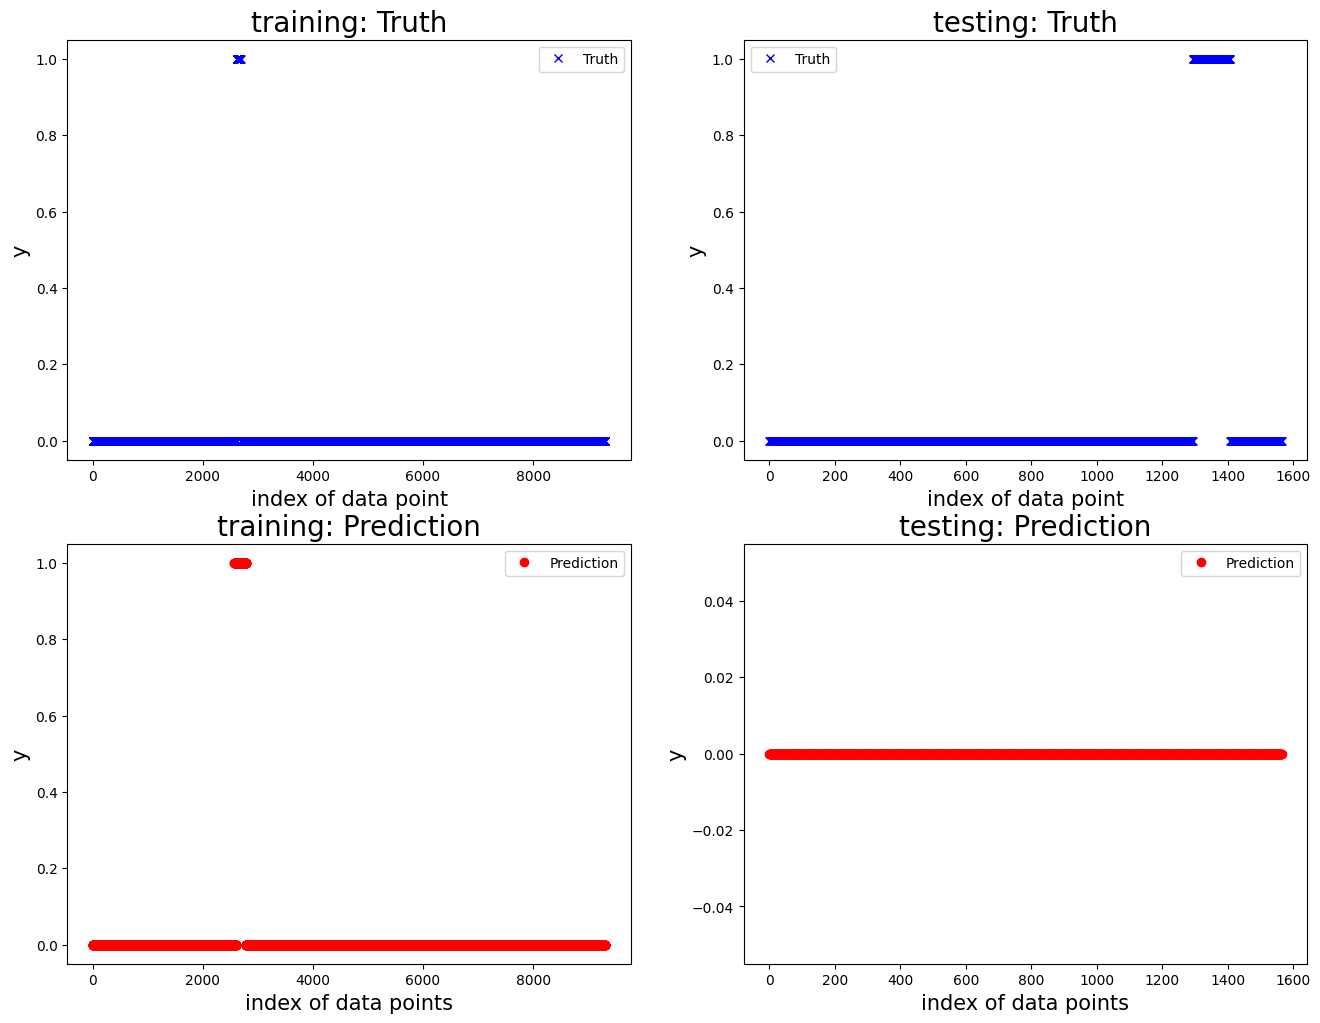


 New run:

training performance, accuracy is: 0.9783567545389271
training performance, precision is: 0.4645669291338583
training performance, recall: 0.9619565217391305
training performance, F1: 0.6265486725663717



 New run:

testing performance, accuracy is: 1.0
testing performance, precision is: 1.0
testing performance, recall: 1.0
testing performance, F1: 1.0




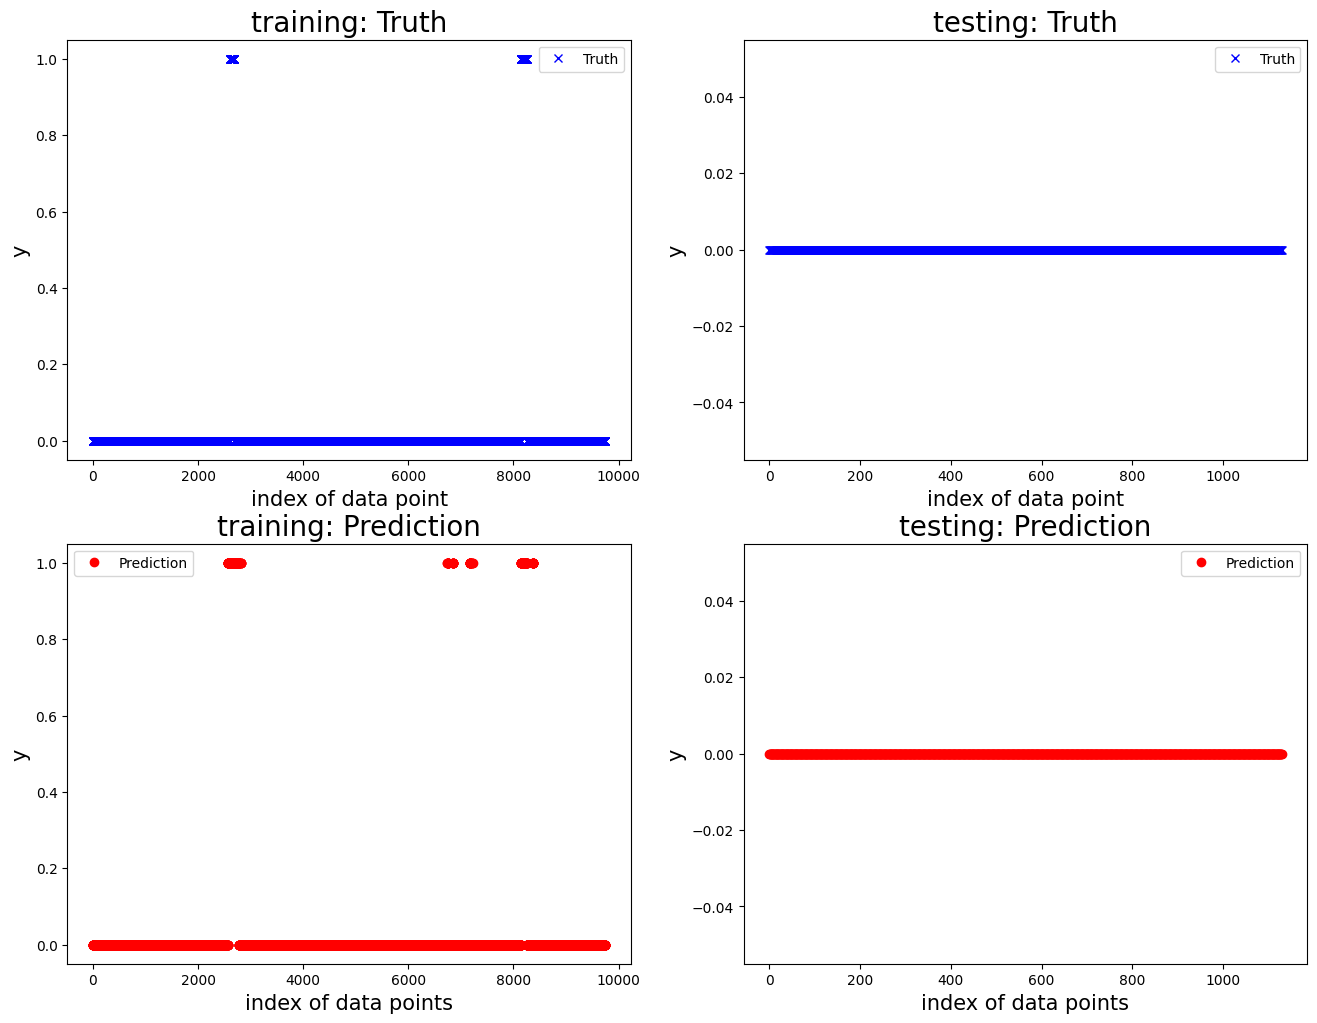


 New run:

training performance, accuracy is: 0.9835906398679484
training performance, precision is: 0.5226586102719033
training performance, recall: 0.9402173913043478
training performance, F1: 0.6718446601941748



 New run:

testing performance, accuracy is: 0.846551724137931
testing performance, precision is: 0.0
testing performance, recall: 0.0
testing performance, F1: 0.0




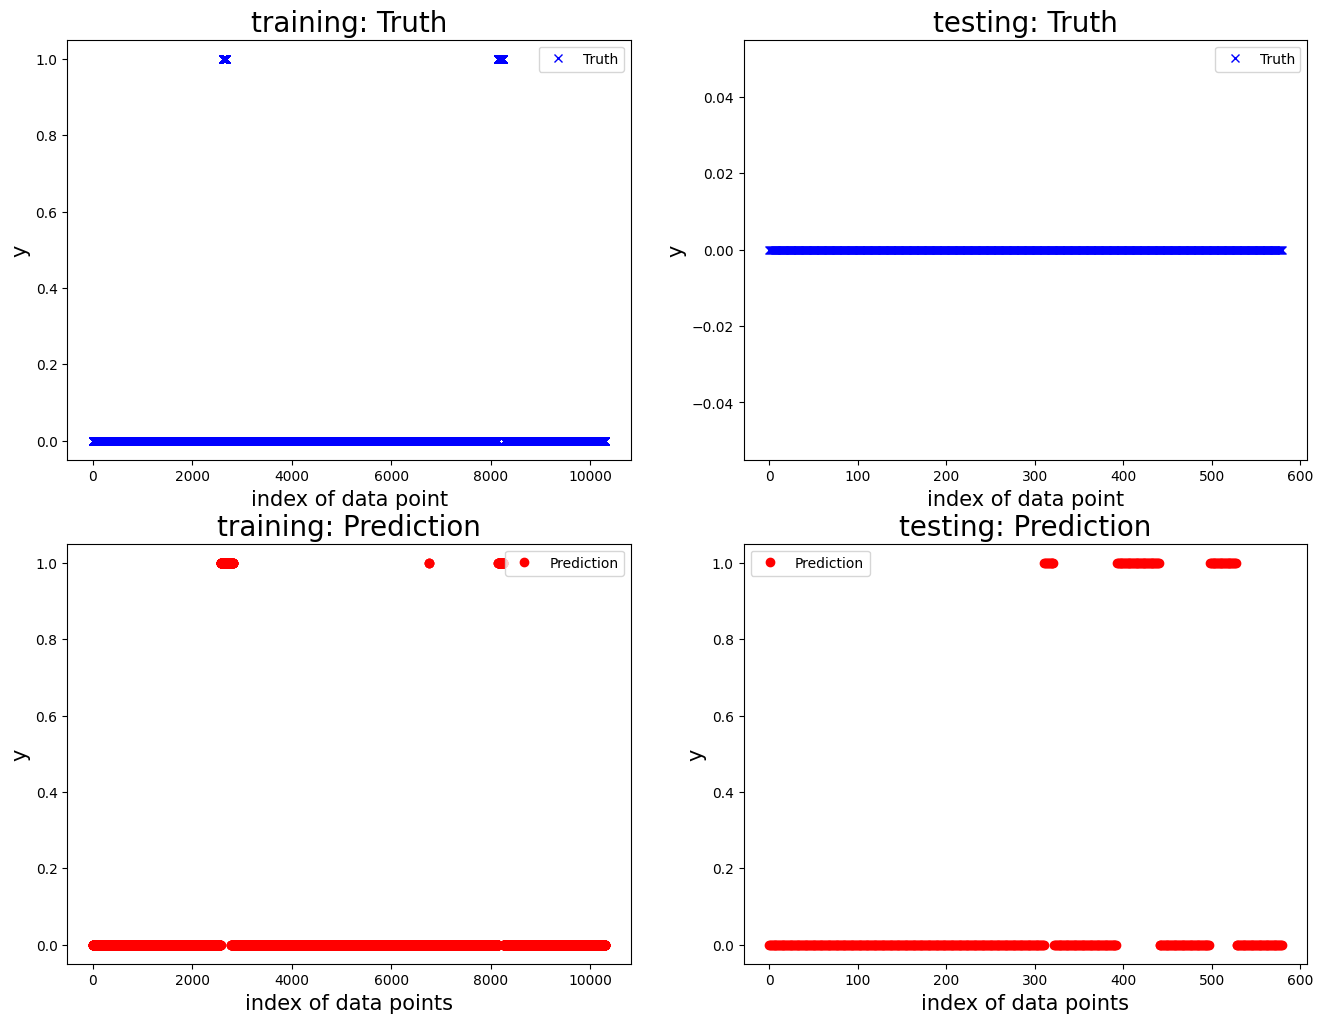


 New run:

training performance, accuracy is: 0.976484537101077
training performance, precision is: 0.43414634146341463
training performance, recall: 0.967391304347826
training performance, F1: 0.5993265993265994



 New run:

testing performance, accuracy is: 1.0
testing performance, precision is: 1.0
testing performance, recall: 1.0
testing performance, F1: 1.0




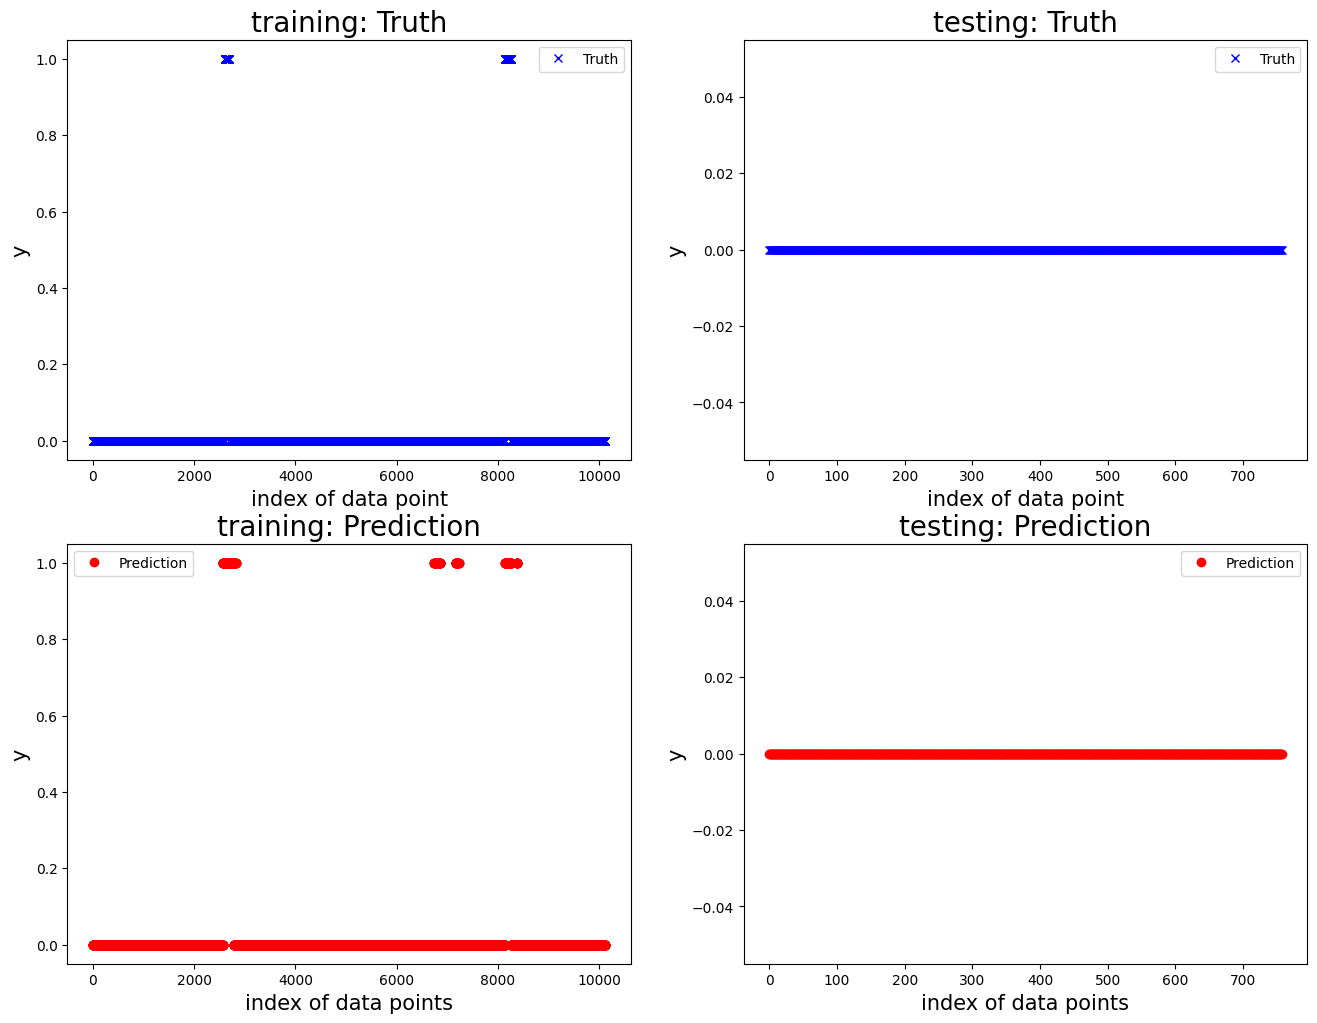

   Accuracy  Precision  Recall  F1 score
0  0.988459        0.0     0.0       0.0
1  0.927203        0.0     0.0       0.0
2  1.000000        1.0     1.0       1.0
3  0.846552        0.0     0.0       0.0
4  1.000000        1.0     1.0       1.0


Mean performance metric and standard error:
Accuracy: 0.9524 +- 0.0665
Precision: 0.4000 +- 0.5477
Recall: 0.4000 +- 0.5477
F1 score: 0.4000 +- 0.5477




,Accuracy,Precision,Recall,F1 score
0,0.988459,0.0,0.0,0.0
1,0.927203,0.0,0.0,0.0
2,1.000000,1.0,1.0,1.0
3,0.846552,0.0,0.0,0.0
4,1.000000,1.0,1.0,1.0


In [21]:
from utility import extract_selected_feature, prepare_sliding_window, run_cv_one_motor
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

# Define the motor index.
motor_idx = 5

# Specify the test conditions you would like to include in the training.
df_data_experiment = df_train[df_train['test_condition'].isin(['20240425_093699', '20240425_094425', '20240426_140055',
                                                       '20240503_164675', '20240503_165189',
                                                       '20240503_163963', '20240325_155003'])]

# Define the features.
feature_list_all = ['time', 'data_motor_1_position', 'data_motor_1_temperature', 'data_motor_1_voltage',
                    'data_motor_2_position', 'data_motor_2_temperature', 'data_motor_2_voltage',
                    'data_motor_3_position', 'data_motor_3_temperature', 'data_motor_3_voltage',
                    'data_motor_4_position', 'data_motor_4_temperature', 'data_motor_4_voltage',
                    'data_motor_5_position', 'data_motor_5_temperature', 'data_motor_5_voltage',
                    'data_motor_6_position', 'data_motor_6_temperature', 'data_motor_6_voltage']

# Define the classification model.
# Define the steps of the pipeline
steps = [
    ('standardizer', StandardScaler()),  # Step 1: StandardScaler
    ('mdl', SVC(class_weight="balanced"))   
]

# Create the pipeline
pipeline = Pipeline(steps)

# Define hyperparameters to search
param_grid_5 = {
    'mdl__C': [0.1, 1, 10]  # Inverse of regularization strength
}

# Initialize GridSearchCV
grid_search_5 = GridSearchCV(estimator=pipeline, param_grid=param_grid_5, scoring='f1', cv=5)

feature_list_motor5 = ['data_motor_1_temperature', 'data_motor_2_voltage',
                    'data_motor_5_voltage', 'data_motor_5_temperature']

# Train the model.
run_cv_one_motor(single_run_result=True, motor_idx=5, df_data=df_data_experiment, mdl=grid_search_5, feature_list=feature_list_motor5, n_fold=5, window_size=20, sample_step=5)

In [22]:
df_tr_x, df_tr_y = extract_selected_feature(df_data_experiment, feature_list_motor5, motor_idx = 5, mdl_type='clf')

# Prepare for the testing dataset.

feature_list_test = ['data_motor_1_temperature', 'data_motor_2_voltage',
                    'data_motor_5_voltage', 'data_motor_5_temperature', 'test_condition']

# Get the features.
feature_list_motor5 = feature_list_motor5 + ['test_condition']

df_test_x = df_test[feature_list_motor5]

grid_search_5.fit(df_tr_x, df_tr_y)

y_pred_5 = grid_search_5.predict(df_test_x)

## Model for motor 3.

Please copy this section for the other motors as well.

### Summary of the mode 3.

In this section, please give a brief summary of the final model you used for this motor. Important details include but not limited to:
- Which model
- What are the features you used?
- Do you tune hyperparameters? If yes, how?
- Do you consider the imbalance in the data? If yes, how?

### Training

In this section, summarize how do you train your model, and put the code here.

Model for motor 3:

 New run:

training performance, accuracy is: 0.9952592481988876
training performance, precision is: 0.0
training performance, recall: 0.0
training performance, F1: 0.0



 New run:

testing performance, accuracy is: 1.0
testing performance, precision is: 1.0
testing performance, recall: 1.0
testing performance, F1: 1.0




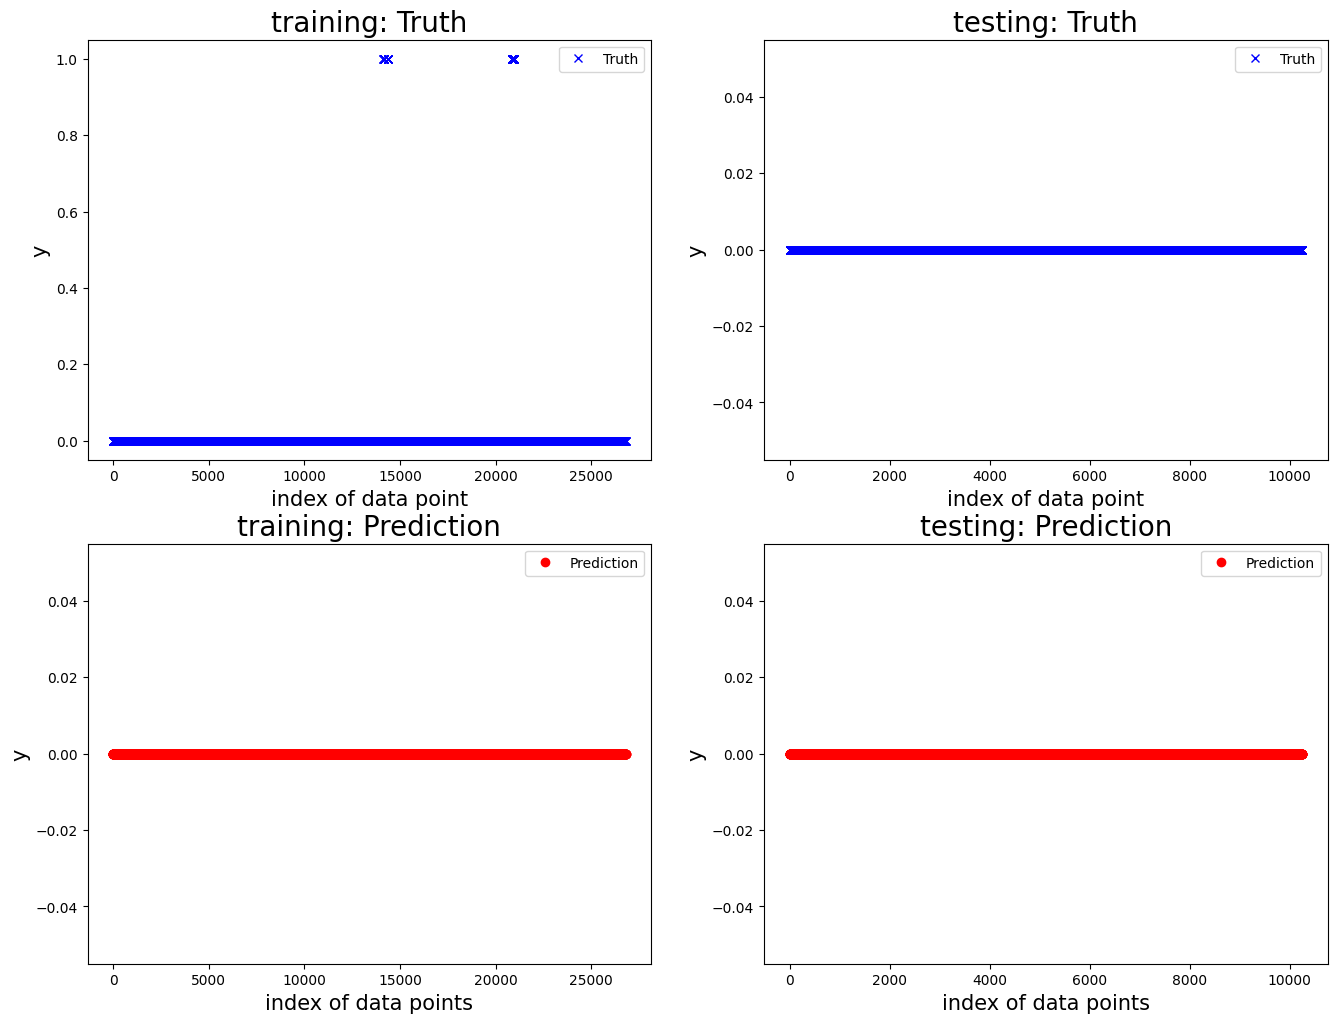


 New run:

training performance, accuracy is: 0.9951546993578517
training performance, precision is: 0.0
training performance, recall: 0.0
training performance, F1: 0.0



 New run:

testing performance, accuracy is: 0.9977891669178977
testing performance, precision is: 0.0
testing performance, recall: 0.0
testing performance, F1: 0.0




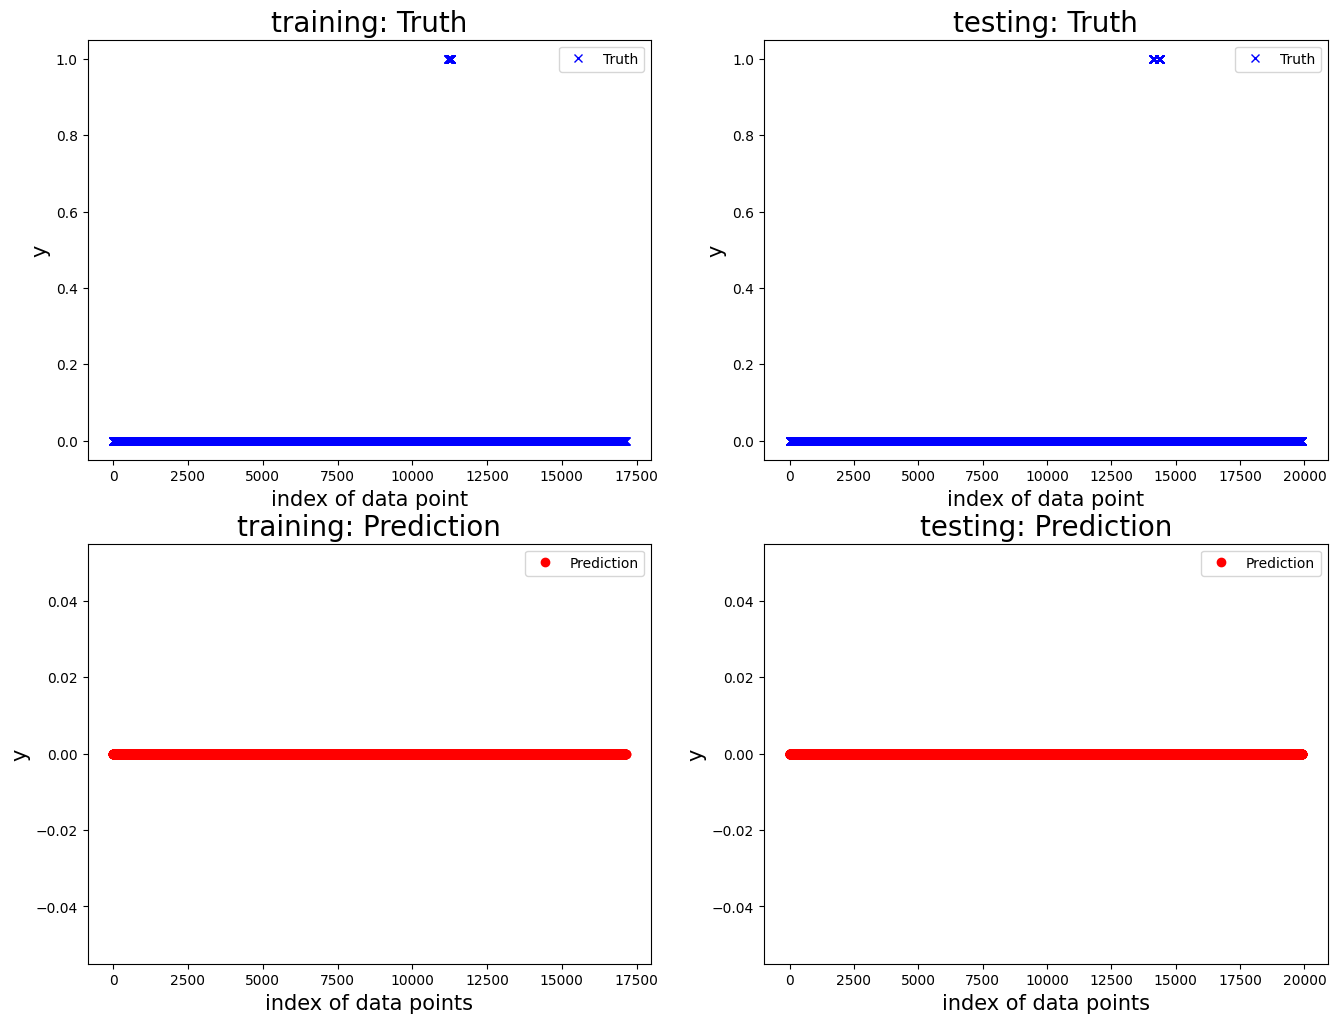


 New run:

training performance, accuracy is: 0.9992354065578591
training performance, precision is: 1.0
training performance, recall: 0.4090909090909091
training performance, F1: 0.5806451612903226



 New run:

testing performance, accuracy is: 0.9682854311199207
testing performance, precision is: 0.0
testing performance, recall: 0.0
testing performance, F1: 0.0




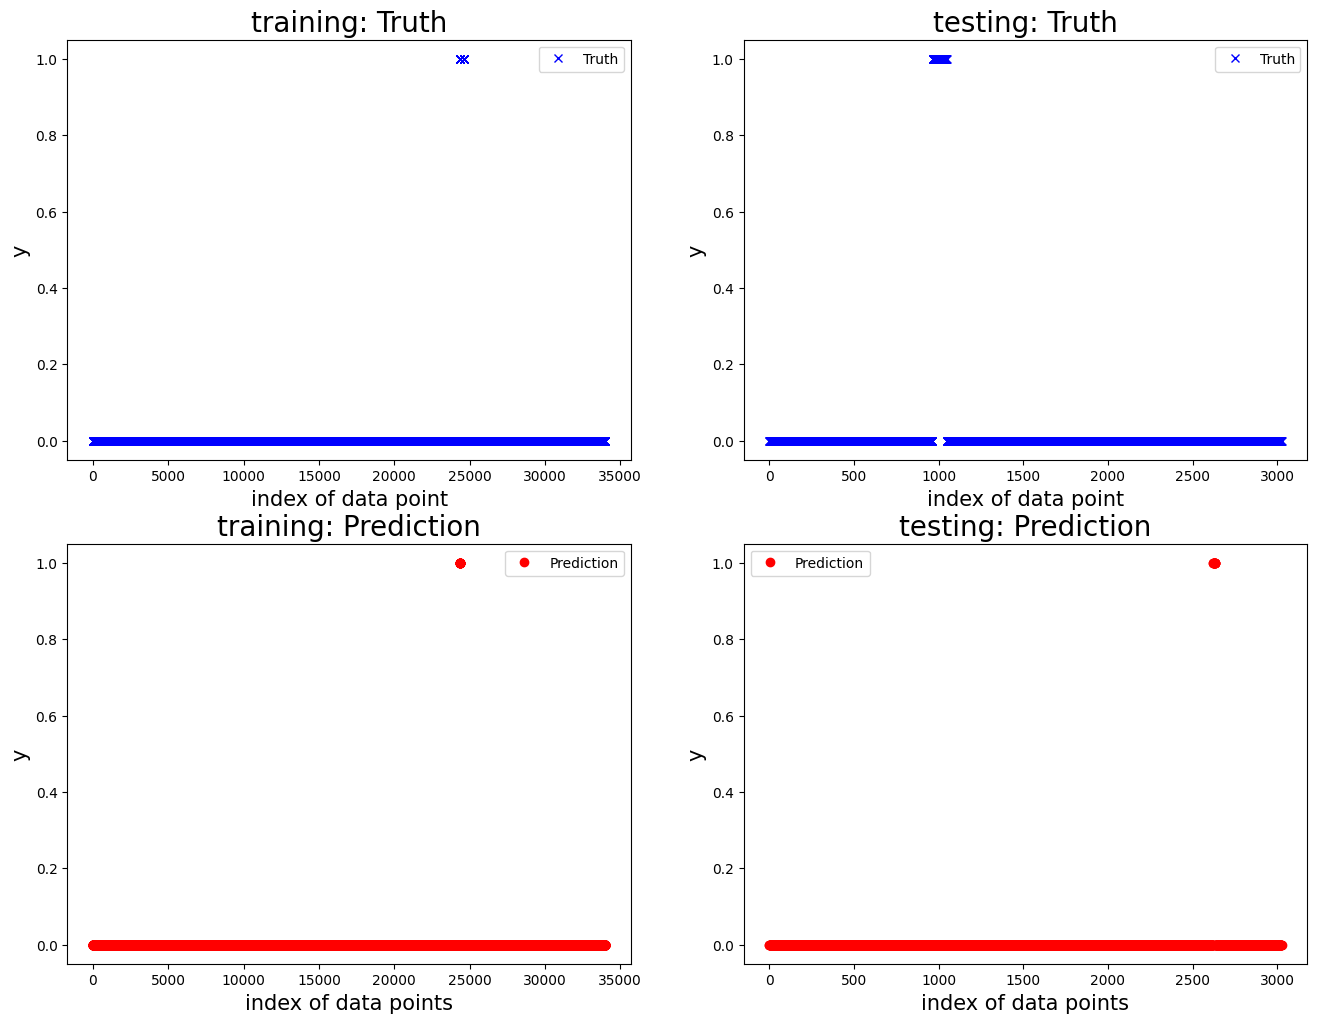


 New run:

training performance, accuracy is: 0.9967029972752044
training performance, precision is: 1.0
training performance, recall: 0.047244094488188976
training performance, F1: 0.09022556390977443



 New run:

testing performance, accuracy is: 1.0
testing performance, precision is: 1.0
testing performance, recall: 1.0
testing performance, F1: 1.0




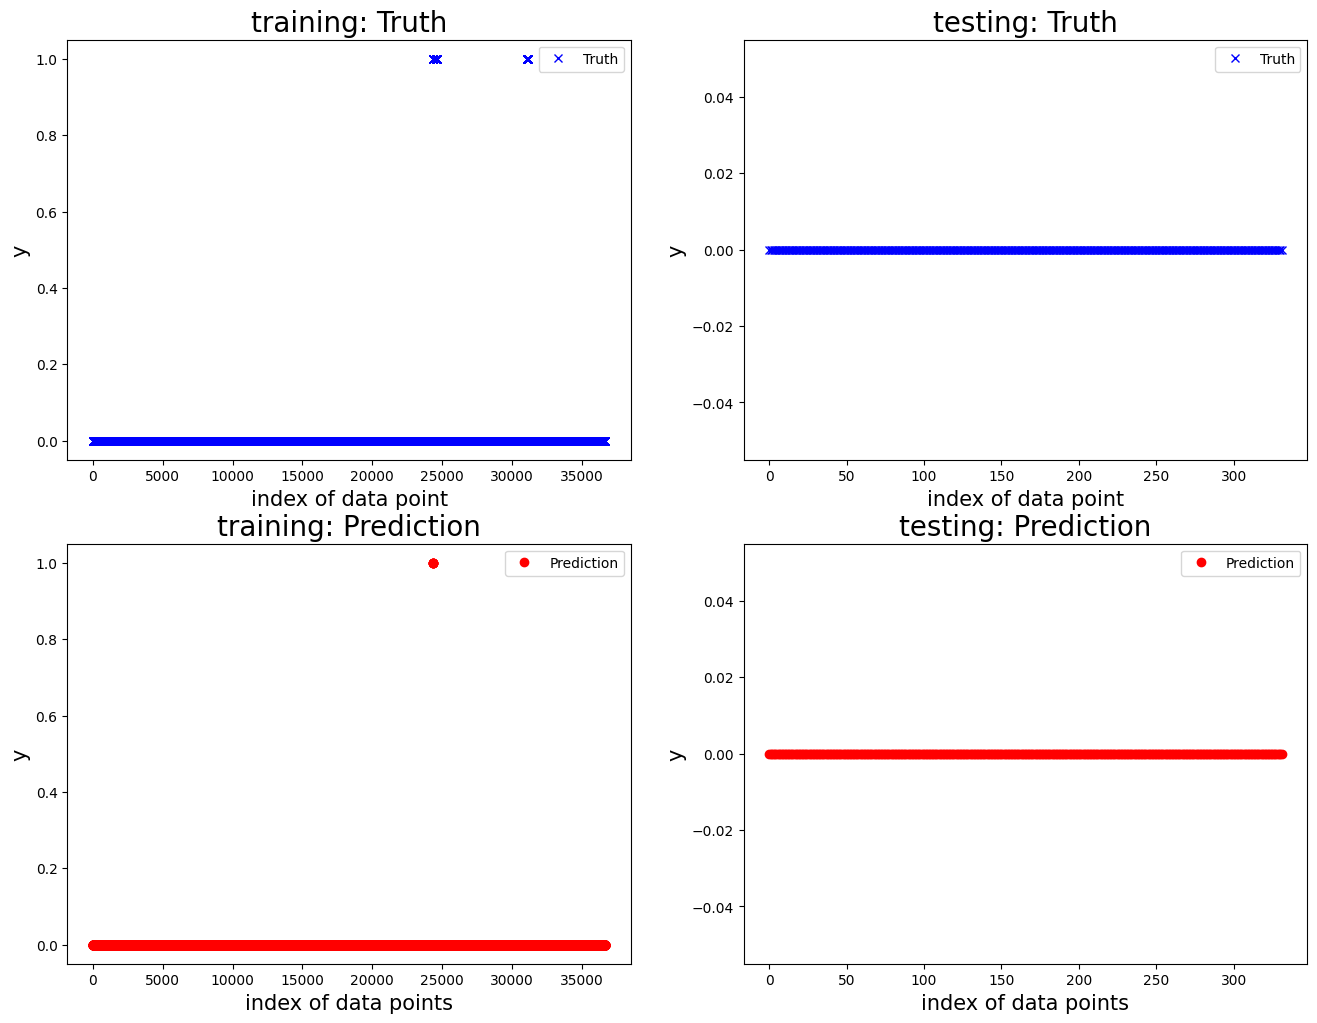


 New run:

training performance, accuracy is: 0.9963287965616046
training performance, precision is: 1.0
training performance, recall: 0.031496062992125984
training performance, F1: 0.061068702290076333



 New run:

testing performance, accuracy is: 1.0
testing performance, precision is: 1.0
testing performance, recall: 1.0
testing performance, F1: 1.0




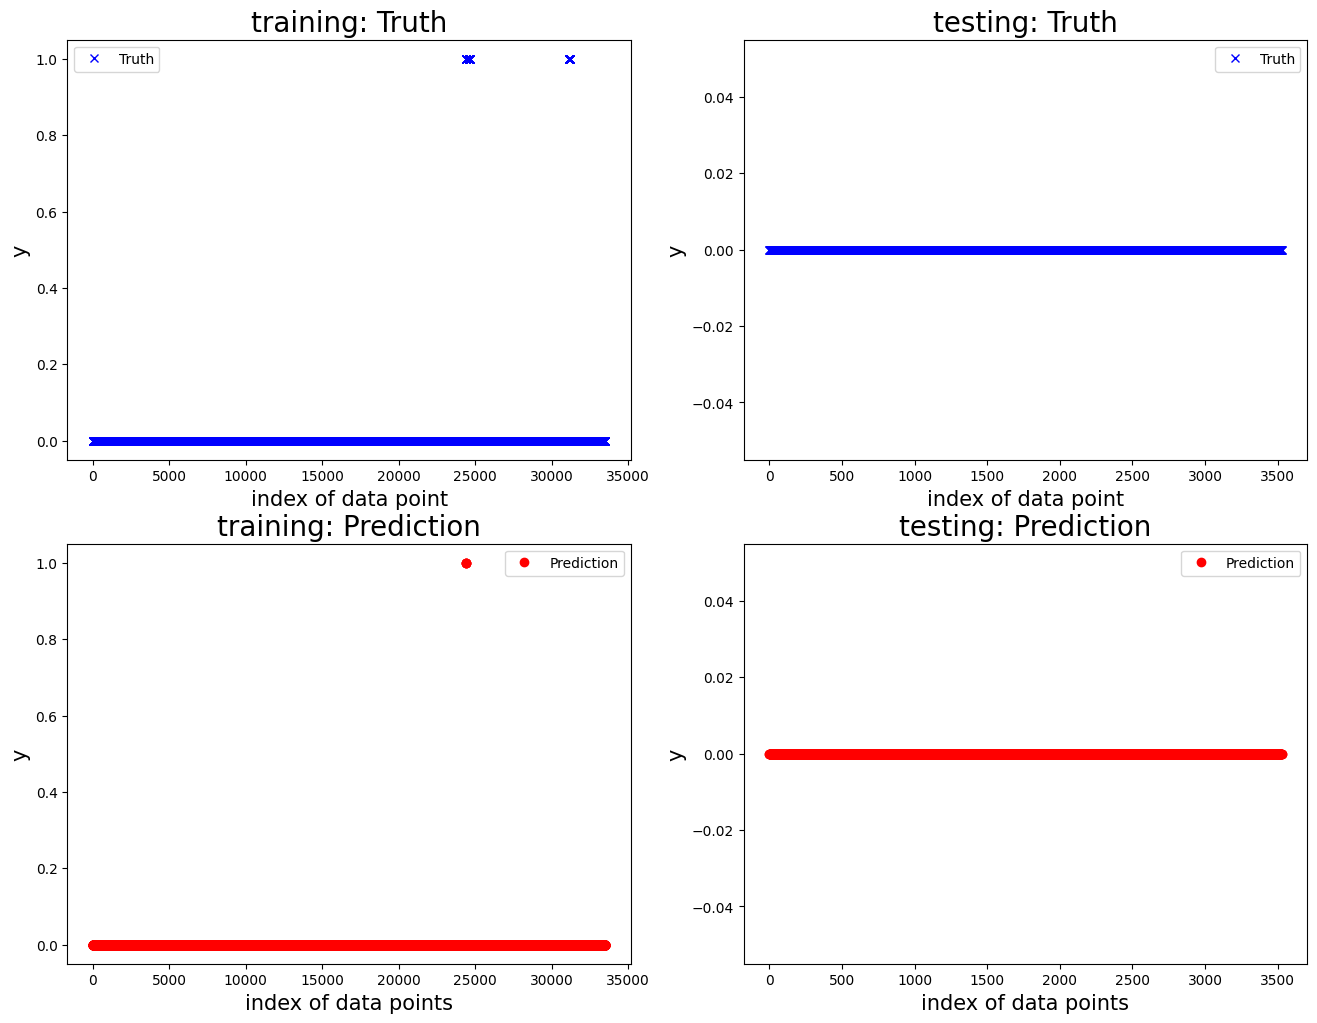

   Accuracy  Precision  Recall  F1 score
0  1.000000        1.0     1.0       1.0
1  0.997789        0.0     0.0       0.0
2  0.968285        0.0     0.0       0.0
3  1.000000        1.0     1.0       1.0
4  1.000000        1.0     1.0       1.0


Mean performance metric and standard error:
Accuracy: 0.9932 +- 0.0140
Precision: 0.6000 +- 0.5477
Recall: 0.6000 +- 0.5477
F1 score: 0.6000 +- 0.5477




In [23]:
from utility import extract_selected_feature, prepare_sliding_window, run_cv_one_motor
from sklearn.linear_model import LogisticRegression

# Define the motor index.
motor_idx = 3

# Specify the test conditions you would like to include in the training.
df_data_experiment = df_train[df_train['test_condition'].isin(not_moving_train + pickup_and_place_train + moving_motor_mixed_train)]

# Define the features.
feature_list_all = ['time', 'data_motor_1_position', 'data_motor_1_temperature', 'data_motor_1_voltage',
                    'data_motor_2_position', 'data_motor_2_temperature', 'data_motor_2_voltage',
                    'data_motor_3_position', 'data_motor_3_temperature', 'data_motor_3_voltage',
                    'data_motor_4_position', 'data_motor_4_temperature', 'data_motor_4_voltage',
                    'data_motor_5_position', 'data_motor_5_temperature', 'data_motor_5_voltage',
                    'data_motor_6_position', 'data_motor_6_temperature', 'data_motor_6_voltage']

feature_list_motor3 = ['data_motor_1_temperature', 'data_motor_1_position',
                       'data_motor_4_position', 'data_motor_4_position']

# Extract the features.
df_tr_x, df_tr_y = extract_selected_feature(df_data_experiment, feature_list_all, motor_idx, mdl_type='clf')

# Prepare the training data based on the defined sliding window.
window_size = 100
sample_step = 1
X_train, y_train = prepare_sliding_window(df_x=df_tr_x, y=df_tr_y, window_size=window_size, sample_step=sample_step, mdl_type='clf')

# Define the classification model.
# Define the steps of the pipeline
steps = [
    ('standardizer', StandardScaler()),  # Step 1: StandardScaler
    ('mdl', LogisticRegression() )   # Step 2: Linear Regression
]

# Create the pipeline
model3 = Pipeline(steps)

# # Define hyperparameters to search
# param_grid = {
#     'mdl__C': [0.001, 0.01, 0.1, 1, 10, 100]  # Inverse of regularization strength
# }

# # Initialize GridSearchCV
# grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring='f1', cv=5)
# mdl = grid_search.fit(X_train, y_train)
# best_params = grid_search.best_params_
# print("Best parameters found: ", best_params)


all_result = run_cv_one_motor(single_run_result=True, motor_idx=motor_idx,  window_size=window_size, sample_step=sample_step,
                              df_data=df_data_experiment, mdl=model3, 
                              feature_list=feature_list_motor3, n_fold=5)
# Train the model.
# mdl = grid_search.fit(X_train, y_train)

In [25]:
df_tr_x, df_tr_y = extract_selected_feature(df_data_experiment, feature_list_motor3, motor_idx = 3, mdl_type='clf')

model3.fit(df_tr_x, df_tr_y)
# Get the features.
feature_list_motor3 += ['test_condition']
df_test_x = df_test[feature_list_motor3]
y_pred_3 = model3.predict(df_test_x)

# Motor 4

Model for motor 4:

 New run:

training performance, accuracy is: 0.9844131921074073
training performance, precision is: 0.9966782663714014
training performance, recall: 0.9376488095238096
training performance, F1: 0.9662628431222205



 New run:

testing performance, accuracy is: 0.9996241661185756
testing performance, precision is: 0.0
testing performance, recall: 0.0
testing performance, F1: 0.0




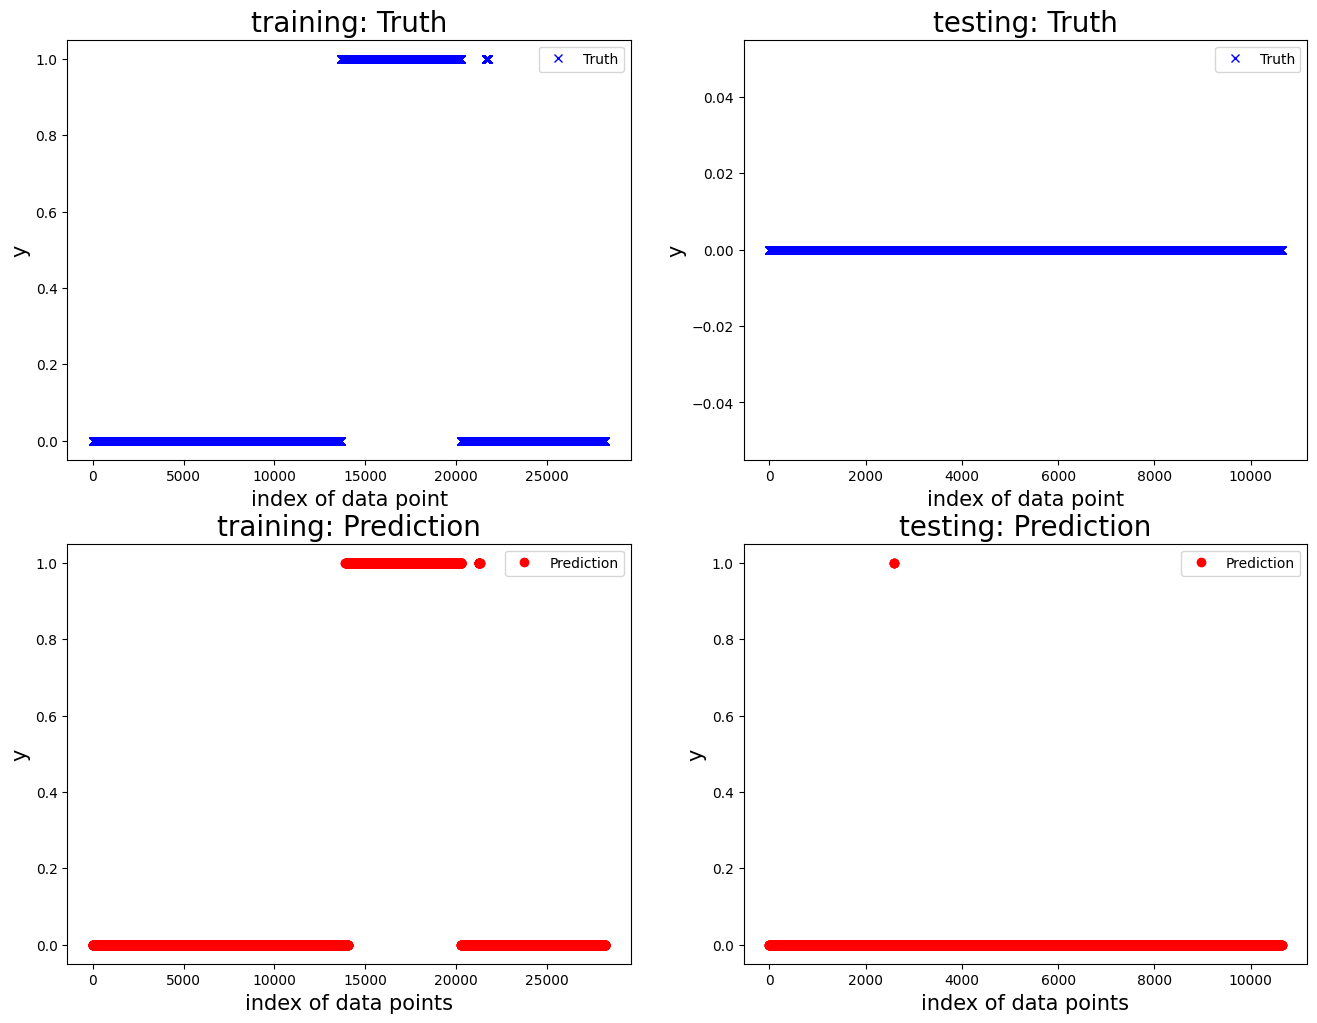


 New run:

training performance, accuracy is: 0.7463651050080775
training performance, precision is: 0.01813633520950594
training performance, recall: 1.0
training performance, F1: 0.03562653562653563



 New run:

testing performance, accuracy is: 0.4868485863461728
testing performance, precision is: 0.3537367648195378
testing performance, recall: 0.6900346751093019
testing performance, F1: 0.4677089720008175




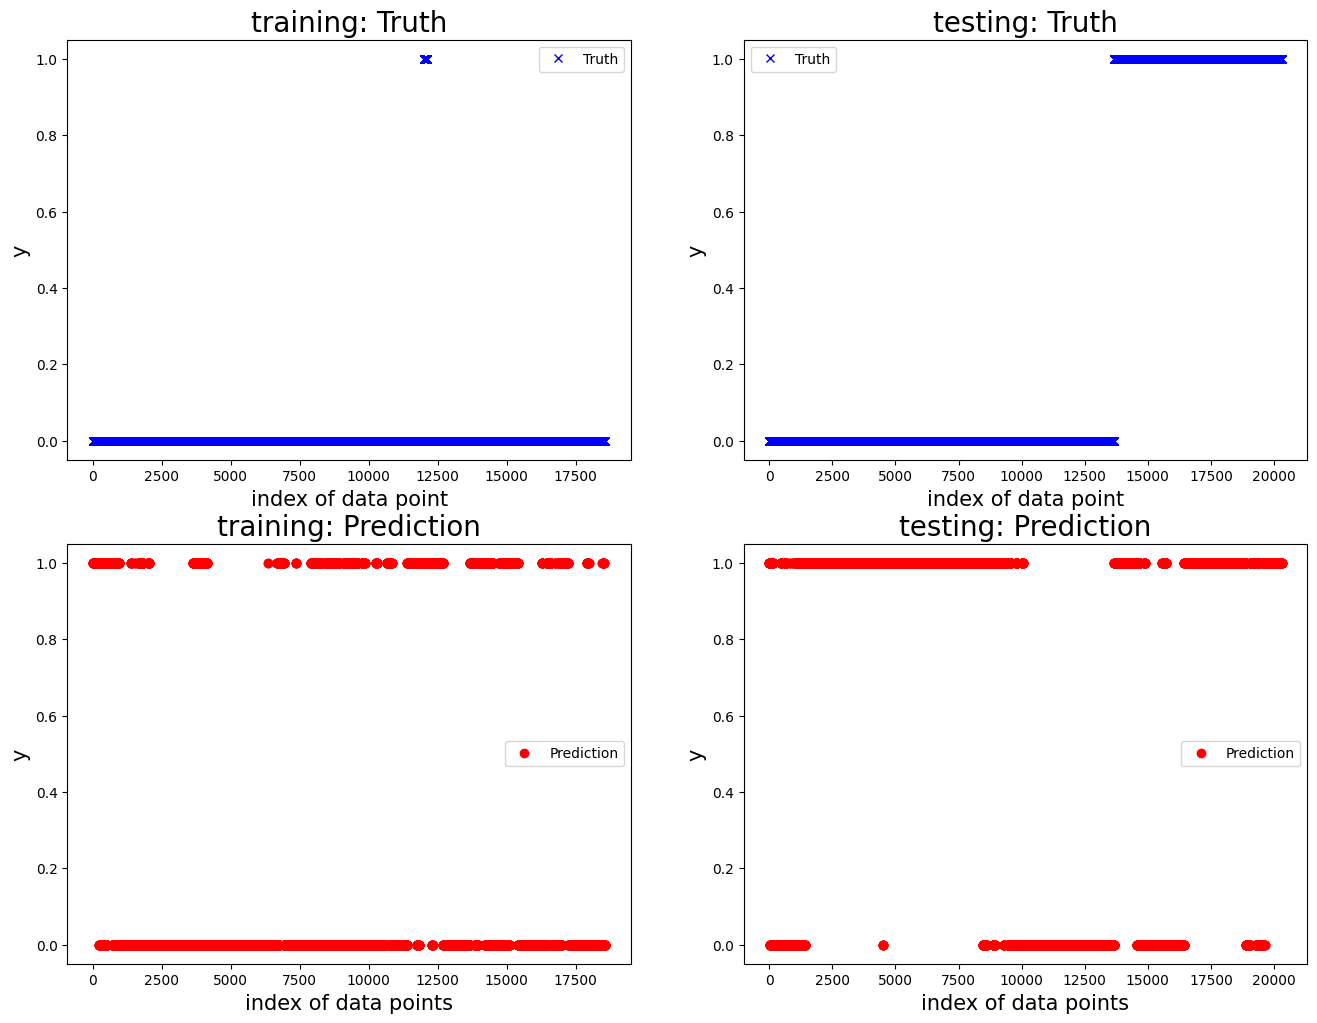


 New run:

training performance, accuracy is: 0.9905769502045423
training performance, precision is: 0.9924941360437842
training performance, recall: 0.956882255389718
training performance, F1: 0.9743629106539761



 New run:

testing performance, accuracy is: 0.9629413481178873
testing performance, precision is: 0.0
testing performance, recall: 0.0
testing performance, F1: 0.0




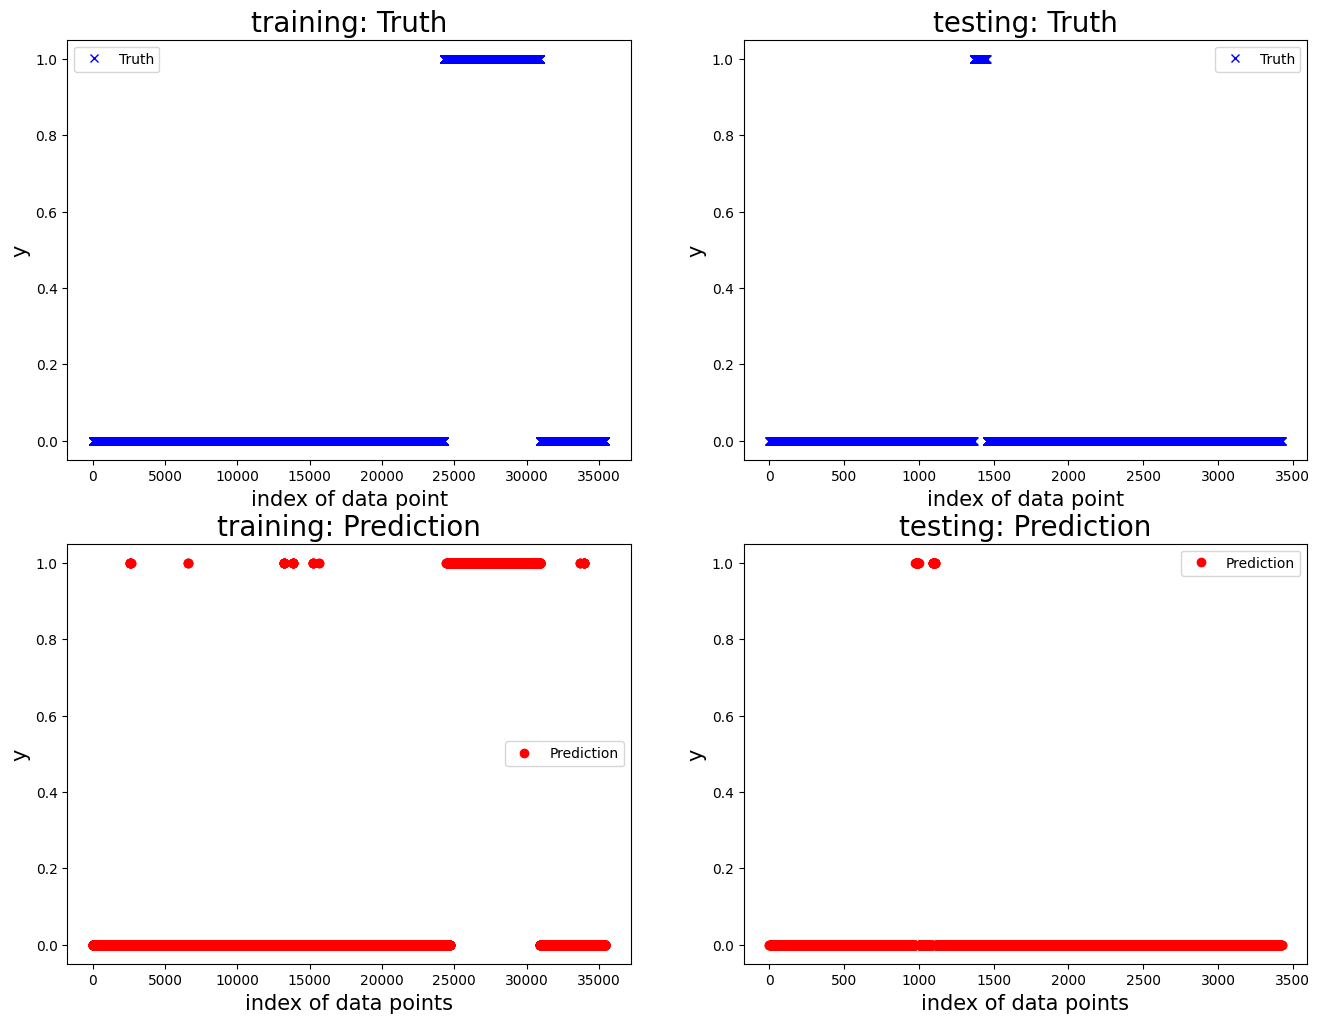


 New run:

training performance, accuracy is: 0.9884615384615385
training performance, precision is: 0.9918533604887984
training performance, recall: 0.9421130952380953
training performance, F1: 0.9663435854384492



 New run:

testing performance, accuracy is: 1.0
testing performance, precision is: 1.0
testing performance, recall: 1.0
testing performance, F1: 1.0




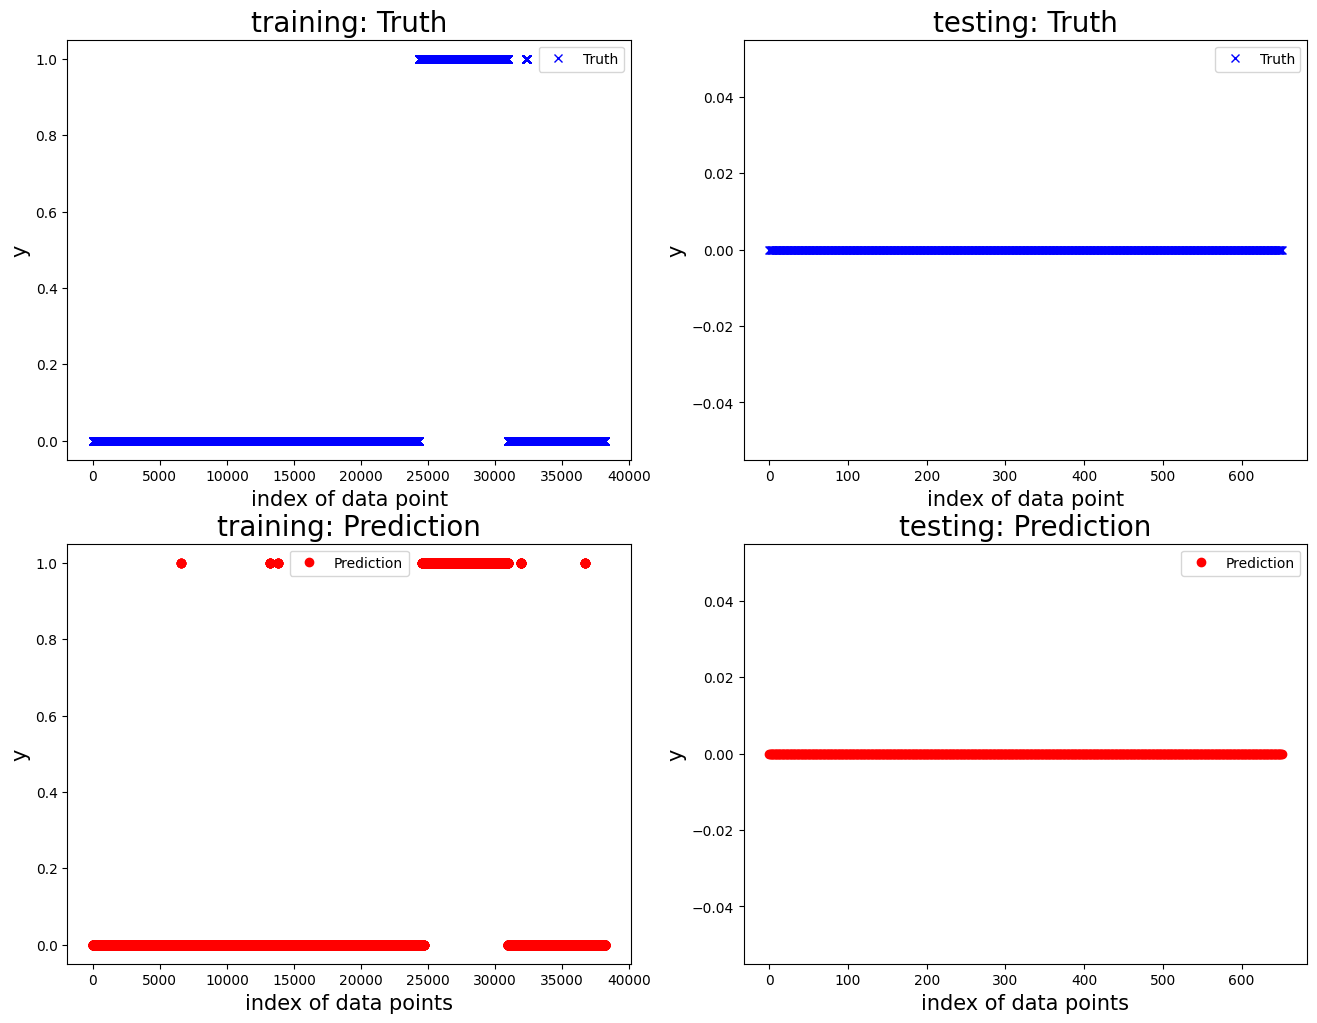


 New run:

training performance, accuracy is: 0.9872373229785291
training performance, precision is: 0.9921544013808253
training performance, recall: 0.9409226190476191
training performance, F1: 0.9658596196440846



 New run:

testing performance, accuracy is: 0.9950623700623701
testing performance, precision is: 0.0
testing performance, recall: 0.0
testing performance, F1: 0.0




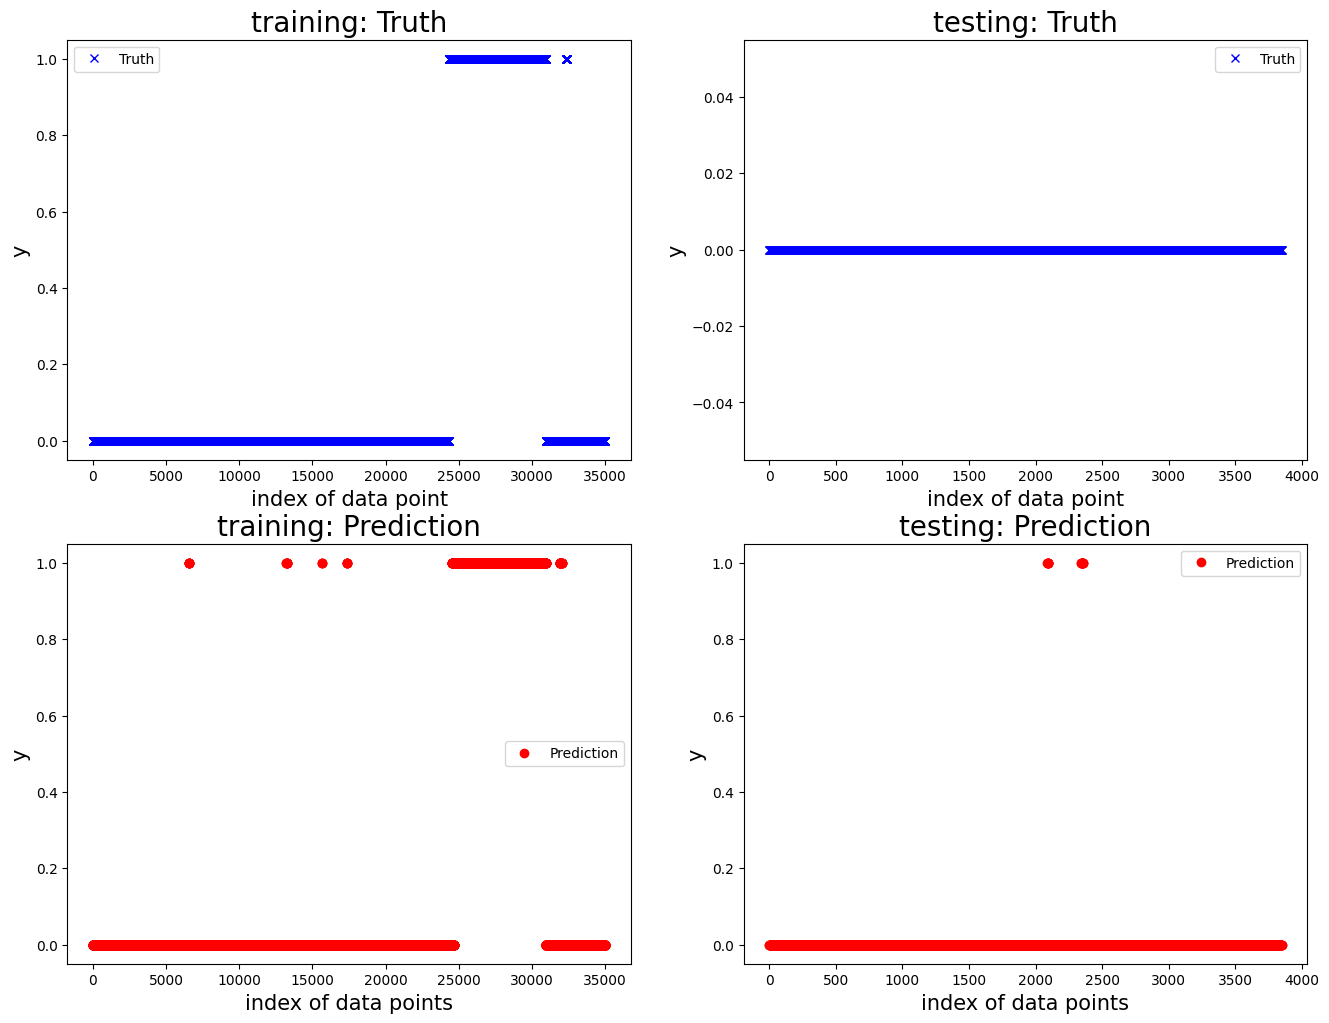

   Accuracy  Precision    Recall  F1 score
0  0.999624   0.000000  0.000000  0.000000
1  0.486849   0.353737  0.690035  0.467709
2  0.962941   0.000000  0.000000  0.000000
3  1.000000   1.000000  1.000000  1.000000
4  0.995062   0.000000  0.000000  0.000000


Mean performance metric and standard error:
Accuracy: 0.8889 +- 0.2253
Precision: 0.2707 +- 0.4355
Recall: 0.3380 +- 0.4756
F1 score: 0.2935 +- 0.4438




In [26]:
from utility import extract_selected_feature, prepare_sliding_window, run_cv_one_motor
from sklearn.linear_model import LogisticRegression

# Define the motor index.
motor_idx = 4

# Specify the test conditions you would like to include in the training.
df_data_experiment = df_train[df_train['test_condition'].isin(not_moving_train + pickup_and_place_train + moving_motor_mixed_train)]

# Define the features.
feature_list_all = ['time', 'data_motor_1_position', 'data_motor_1_temperature', 'data_motor_1_voltage',
                    'data_motor_2_position', 'data_motor_2_temperature', 'data_motor_2_voltage',
                    'data_motor_3_position', 'data_motor_3_temperature', 'data_motor_3_voltage',
                    'data_motor_4_position', 'data_motor_4_temperature', 'data_motor_4_voltage',
                    'data_motor_5_position', 'data_motor_5_temperature', 'data_motor_5_voltage',
                    'data_motor_6_position', 'data_motor_6_temperature', 'data_motor_6_voltage']

feature_list_motor4 = ['data_motor_1_temperature', 'data_motor_2_temperature','data_motor_2_temperature',
                       'data_motor_6_temperature', 'data_motor_6_voltage']

# Extract the features.
df_tr_x, df_tr_y = extract_selected_feature(df_data_experiment, feature_list_all, motor_idx, mdl_type='clf')

# Prepare the training data based on the defined sliding window.
window_size = 20
sample_step = 1
X_train, y_train = prepare_sliding_window(df_x=df_tr_x, y=df_tr_y, window_size=window_size, sample_step=sample_step, mdl_type='clf')

# Define the classification model.
# Define the steps of the pipeline
steps = [
    ('standardizer', StandardScaler()),  # Step 1: StandardScaler
    ('mdl', LogisticRegression(class_weight='balanced') )   # Step 2: Linear Regression
]

# Create the pipeline
model4 = Pipeline(steps)

# # Define hyperparameters to search
# param_grid = {
#     'mdl__C': [0.001, 0.01, 0.1, 1, 10, 100]  # Inverse of regularization strength
# }

# # Initialize GridSearchCV
# grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring='f1', cv=5)
# mdl = grid_search.fit(X_train, y_train)
# best_params = grid_search.best_params_
# print("Best parameters found: ", best_params)


all_result = run_cv_one_motor(single_run_result=True, motor_idx=motor_idx,  window_size=window_size, sample_step=sample_step,
                              df_data=df_data_experiment, mdl=model4, 
                              feature_list=feature_list_motor4, n_fold=5)
# Train the model.
# mdl = grid_search.fit(X_train, y_train)

In [27]:
df_tr_x, df_tr_y = extract_selected_feature(df_data_experiment, feature_list_motor4, motor_idx = 4, mdl_type='clf')

model4.fit(df_tr_x, df_tr_y)
# Get the features.
feature_list_motor4 += ['test_condition']

df_test_x = df_test[feature_list_motor4]
y_pred_4 = model4.predict(df_test_x)

# Motor 1

Model for motor 1:

 New run:

training performance, accuracy is: 0.9680465862854156
training performance, precision is: 0.7578828828828829
training performance, recall: 0.5121765601217656
training performance, F1: 0.6112624886466849



 New run:

testing performance, accuracy is: 1.0
testing performance, precision is: 1.0
testing performance, recall: 1.0
testing performance, F1: 1.0




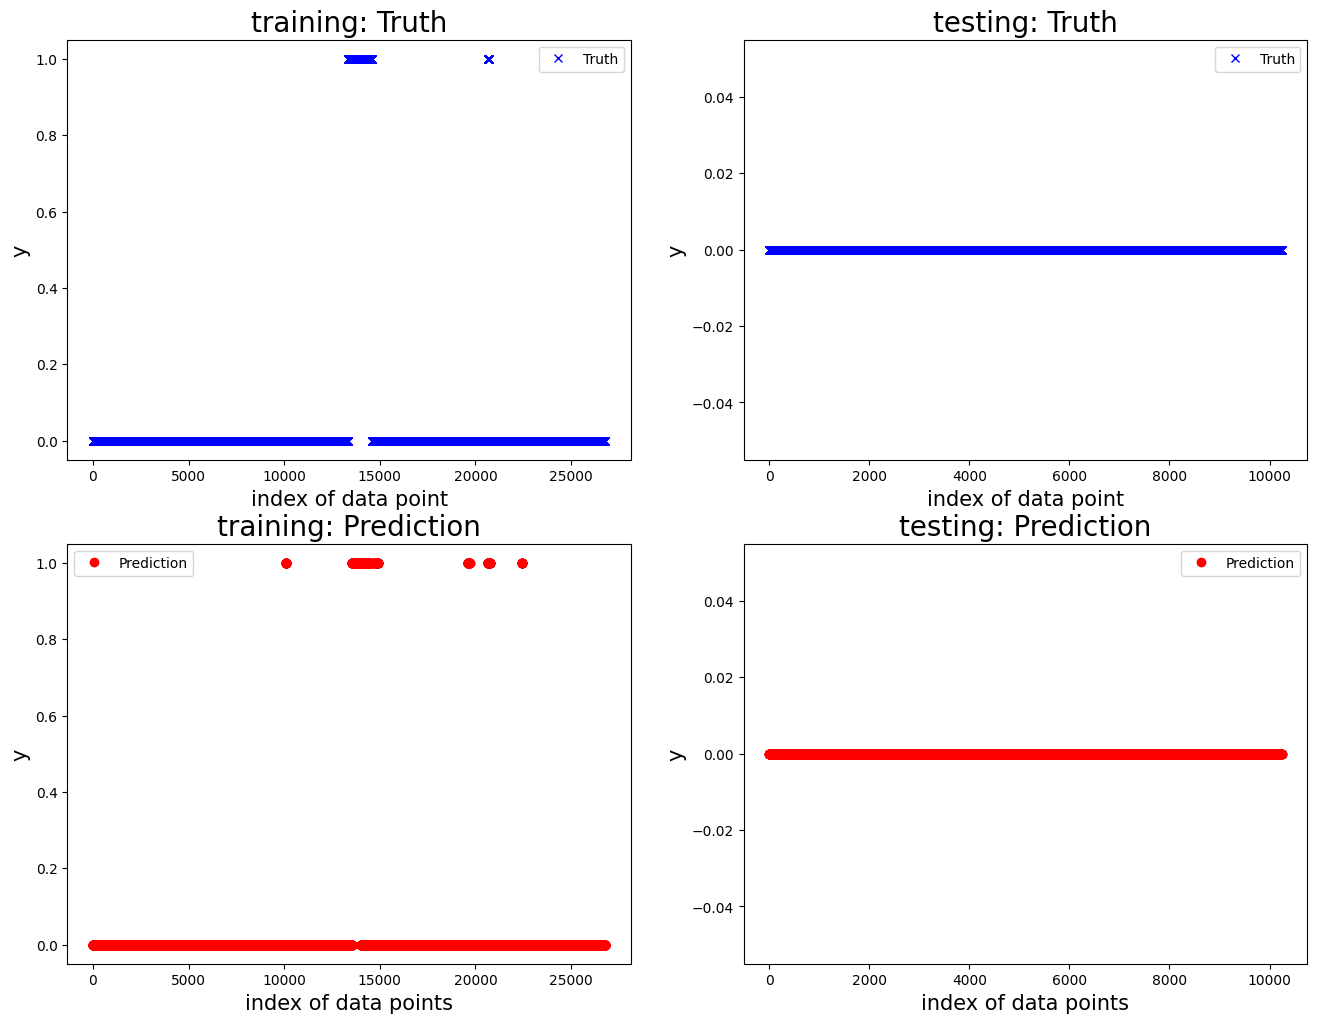


 New run:

training performance, accuracy is: 0.9991827203736136
training performance, precision is: 1.0
training performance, recall: 0.7543859649122807
training performance, F1: 0.86



 New run:

testing performance, accuracy is: 0.8935282886142096
testing performance, precision is: 0.05930470347648262
testing performance, recall: 0.046141607000795545
testing performance, F1: 0.05190156599552573




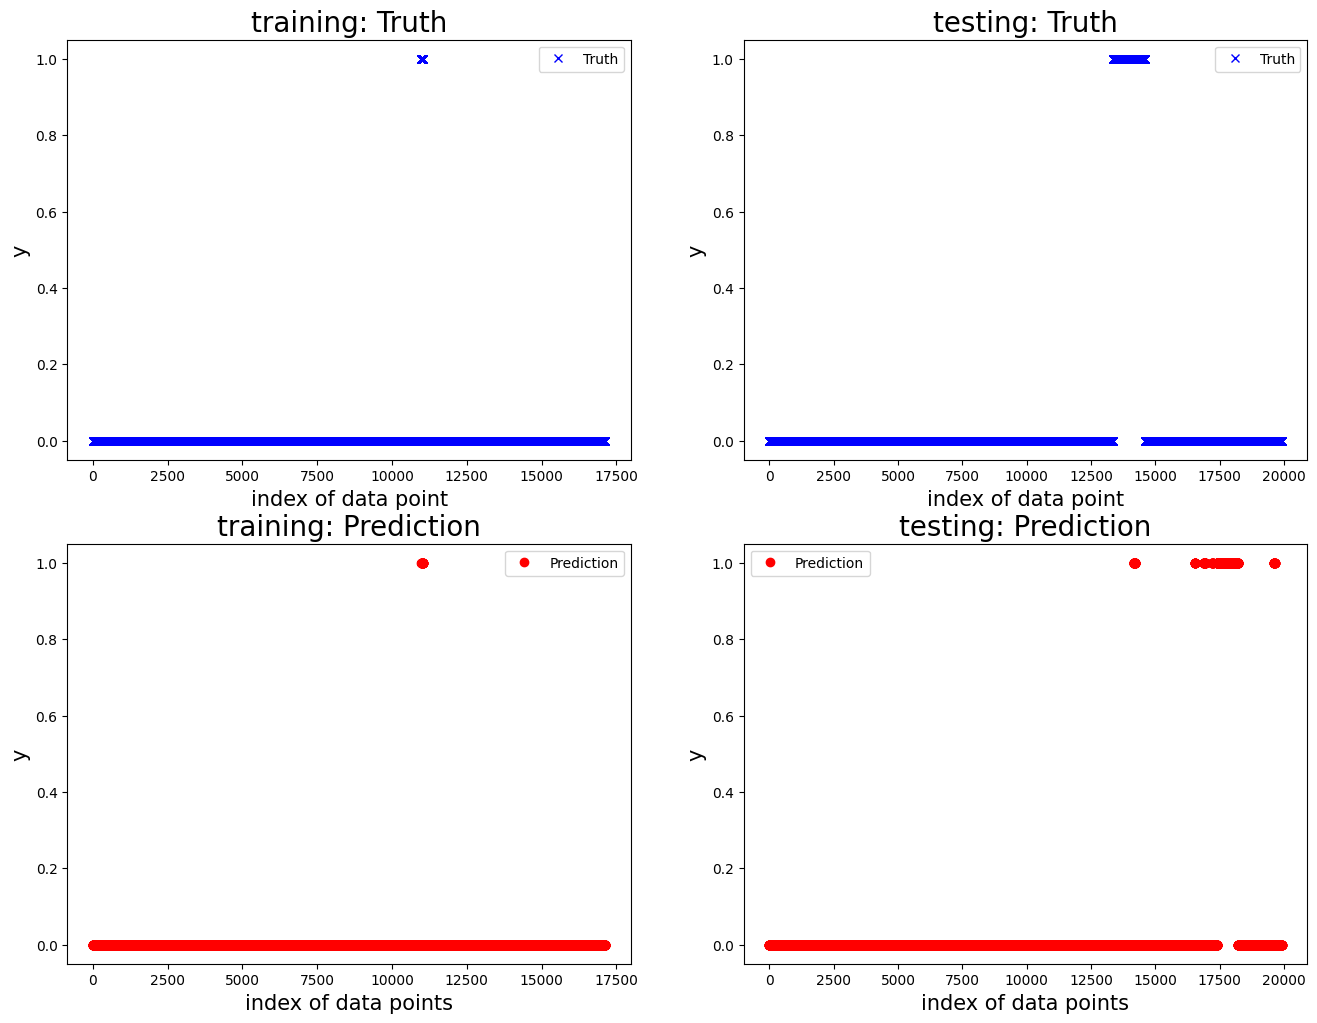


 New run:

training performance, accuracy is: 0.9762387884134686
training performance, precision is: 0.750278706800446
training performance, recall: 0.5354017501988863
training performance, F1: 0.6248839368616528



 New run:

testing performance, accuracy is: 0.9299636603898249
testing performance, precision is: 0.1702127659574468
testing performance, recall: 0.7017543859649122
testing performance, F1: 0.273972602739726




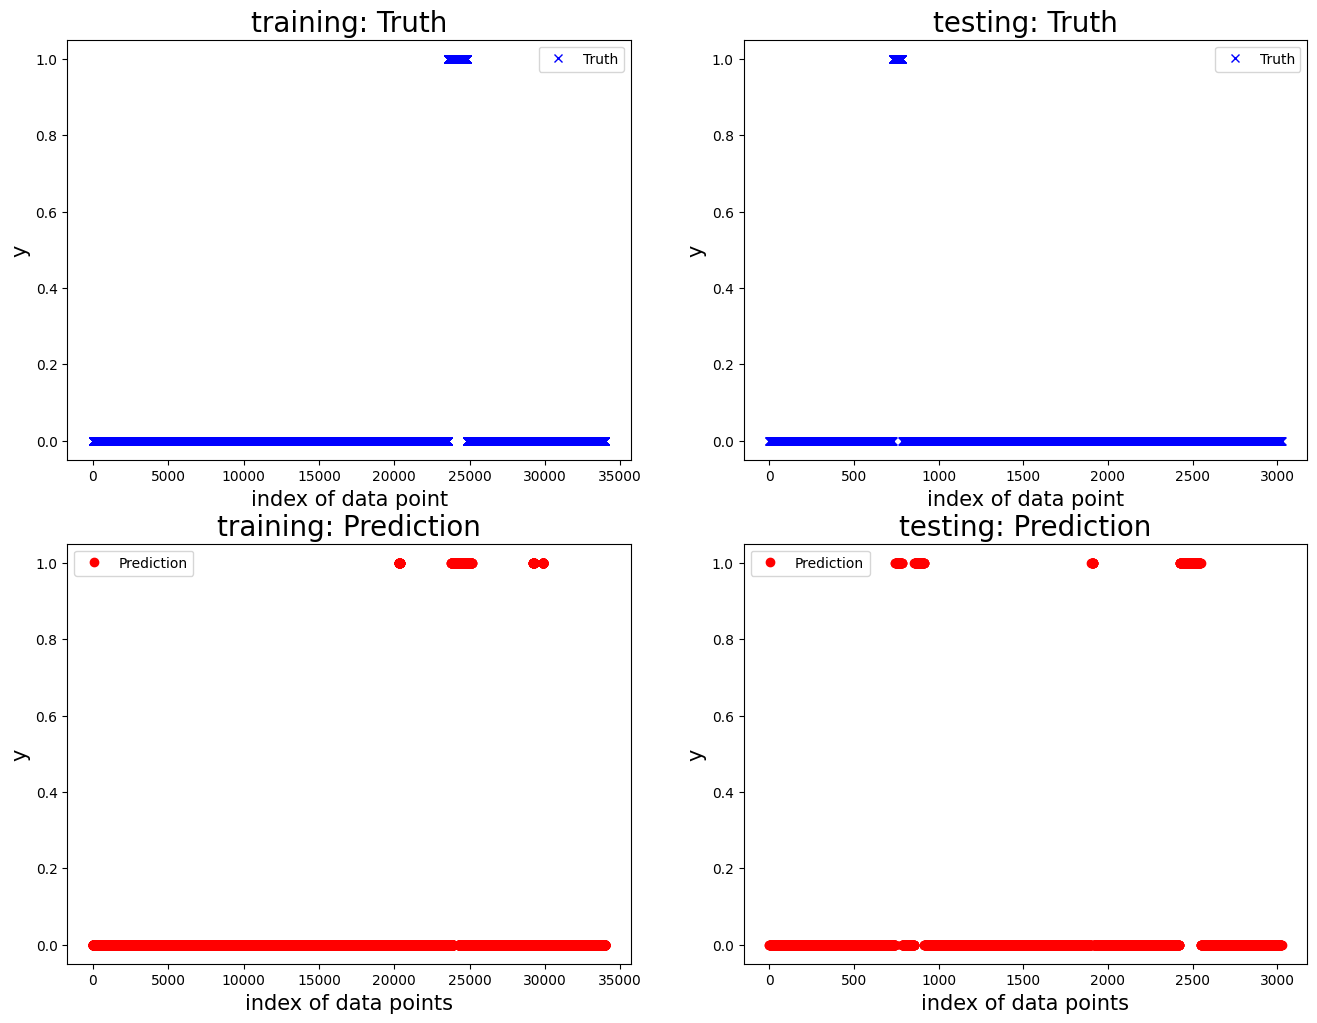


 New run:

training performance, accuracy is: 0.9767574931880109
training performance, precision is: 0.7670915411355735
training performance, recall: 0.5038051750380518
training performance, F1: 0.6081763895268718



 New run:

testing performance, accuracy is: 1.0
testing performance, precision is: 1.0
testing performance, recall: 1.0
testing performance, F1: 1.0




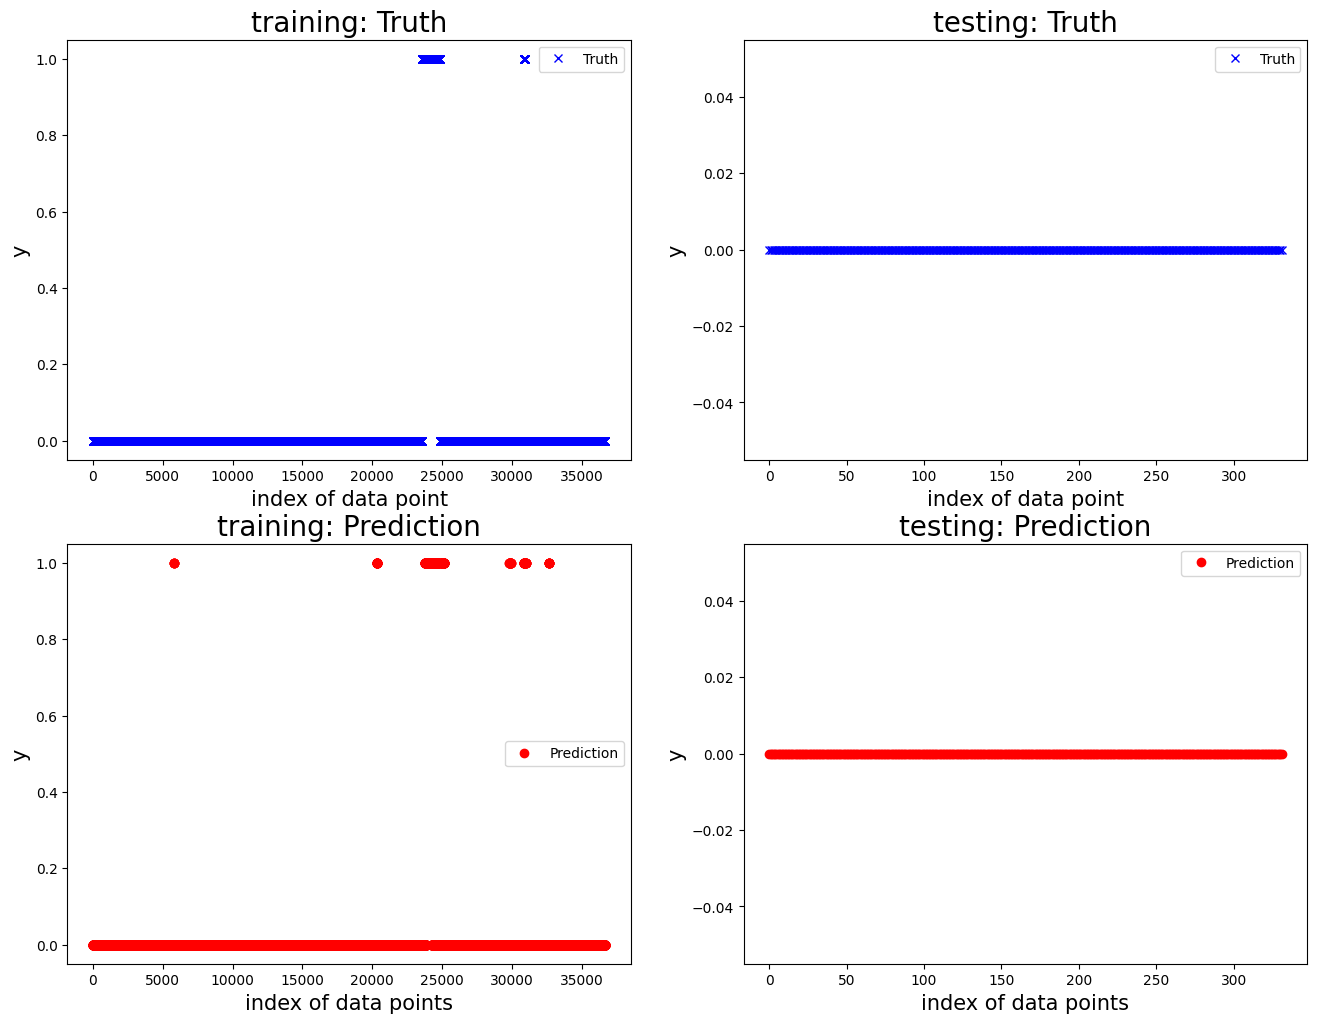


 New run:

training performance, accuracy is: 0.974480659025788
training performance, precision is: 0.7665505226480837
training performance, recall: 0.502283105022831
training performance, F1: 0.6068965517241379



 New run:

testing performance, accuracy is: 1.0
testing performance, precision is: 1.0
testing performance, recall: 1.0
testing performance, F1: 1.0




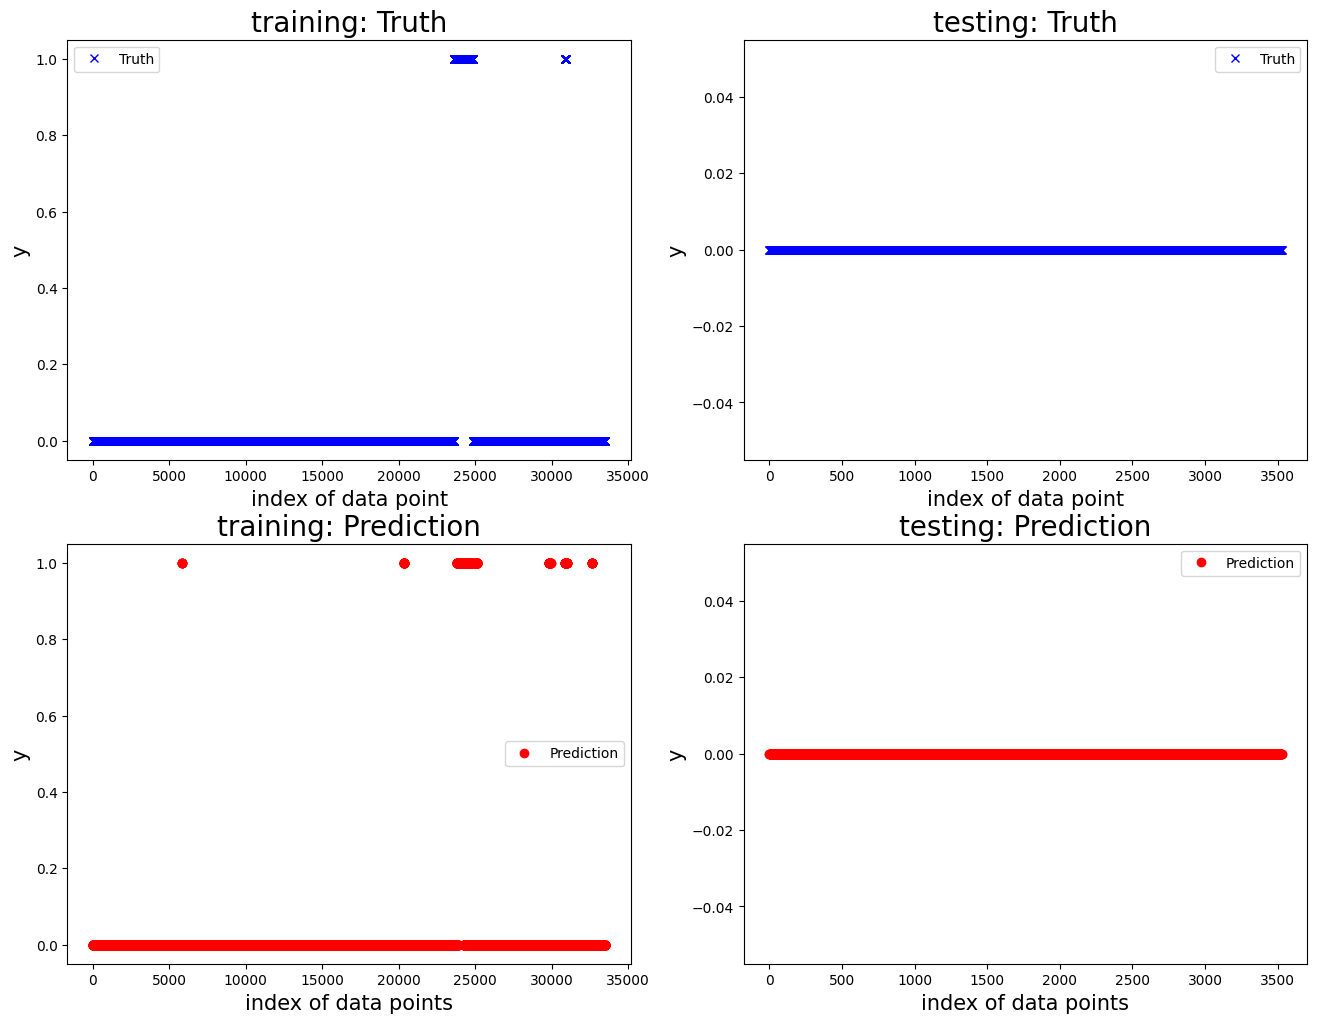

   Accuracy  Precision    Recall  F1 score
0  1.000000   1.000000  1.000000  1.000000
1  0.893528   0.059305  0.046142  0.051902
2  0.929964   0.170213  0.701754  0.273973
3  1.000000   1.000000  1.000000  1.000000
4  1.000000   1.000000  1.000000  1.000000


Mean performance metric and standard error:
Accuracy: 0.9647 +- 0.0500
Precision: 0.6459 +- 0.4864
Recall: 0.7496 +- 0.4139
F1 score: 0.6652 +- 0.4652




In [28]:
from utility import extract_selected_feature, prepare_sliding_window, run_cv_one_motor
from sklearn.linear_model import LogisticRegression

# Define the motor index.
motor_idx = 1

# Specify the test conditions you would like to include in the training.
df_data_experiment = df_train[df_train['test_condition'].isin(not_moving_train + pickup_and_place_train + moving_motor_mixed_train)]

# Define the features.
feature_list_all = ['time', 'data_motor_1_position', 'data_motor_1_temperature', 'data_motor_1_voltage',
                    'data_motor_2_position', 'data_motor_2_temperature', 'data_motor_2_voltage',
                    'data_motor_3_position', 'data_motor_3_temperature', 'data_motor_3_voltage',
                    'data_motor_4_position', 'data_motor_4_temperature', 'data_motor_4_voltage',
                    'data_motor_5_position', 'data_motor_5_temperature', 'data_motor_5_voltage',
                    'data_motor_6_position', 'data_motor_6_temperature', 'data_motor_6_voltage']

feature_list_motor1 = ['data_motor_1_temperature', 'data_motor_1_position', 
                       'data_motor_2_temperature',
                       'data_motor_3_position', 'data_motor_3_temperature'
                       ]

# Extract the features.
df_tr_x, df_tr_y = extract_selected_feature(df_data_experiment, feature_list_motor1, motor_idx, mdl_type='clf')

# Prepare the training data based on the defined sliding window.
window_size = 100
sample_step = 5
X_train, y_train = prepare_sliding_window(df_x=df_tr_x, y=df_tr_y, window_size=window_size, sample_step=sample_step, mdl_type='clf')

# Define the classification model.
# Define the steps of the pipeline
steps = [
    ('standardizer', StandardScaler()),  # Step 1: StandardScaler
    ('mdl', LogisticRegression() )   # Step 2: Linear Regression
]

# Create the pipeline
model1 = Pipeline(steps)

# # Define hyperparameters to search
# param_grid = {
#     'mdl__C': [0.001, 0.01, 0.1, 1, 10, 100]  # Inverse of regularization strength
# }

# # Initialize GridSearchCV
# grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring='f1', cv=5)
# mdl = grid_search.fit(X_train, y_train)
# best_params = grid_search.best_params_
# print("Best parameters found: ", best_params)


all_result = run_cv_one_motor(single_run_result=True, motor_idx=motor_idx,  window_size=window_size, sample_step=sample_step,
                              df_data=df_data_experiment, mdl=model1, 
                              feature_list=feature_list_motor1, n_fold=5)
# Train the model.
# mdl = grid_search.fit(X_train, y_train)

In [29]:
df_tr_x, df_tr_y = extract_selected_feature(df_data_experiment, feature_list_motor1, motor_idx = 1, mdl_type='clf')

model1.fit(df_tr_x, df_tr_y)
# Get the features.
feature_list_motor1 += ['test_condition']

df_test_x = df_test[feature_list_motor1]
y_pred_1 = model1.predict(df_test_x)

# Motor 2

Model for motor 2:

 New run:

training performance, accuracy is: 0.9889829607850084
training performance, precision is: 0.994592088998764
training performance, recall: 0.9588857440786533
training performance, F1: 0.9764125900644672



 New run:

testing performance, accuracy is: 1.0
testing performance, precision is: 1.0
testing performance, recall: 1.0
testing performance, F1: 1.0




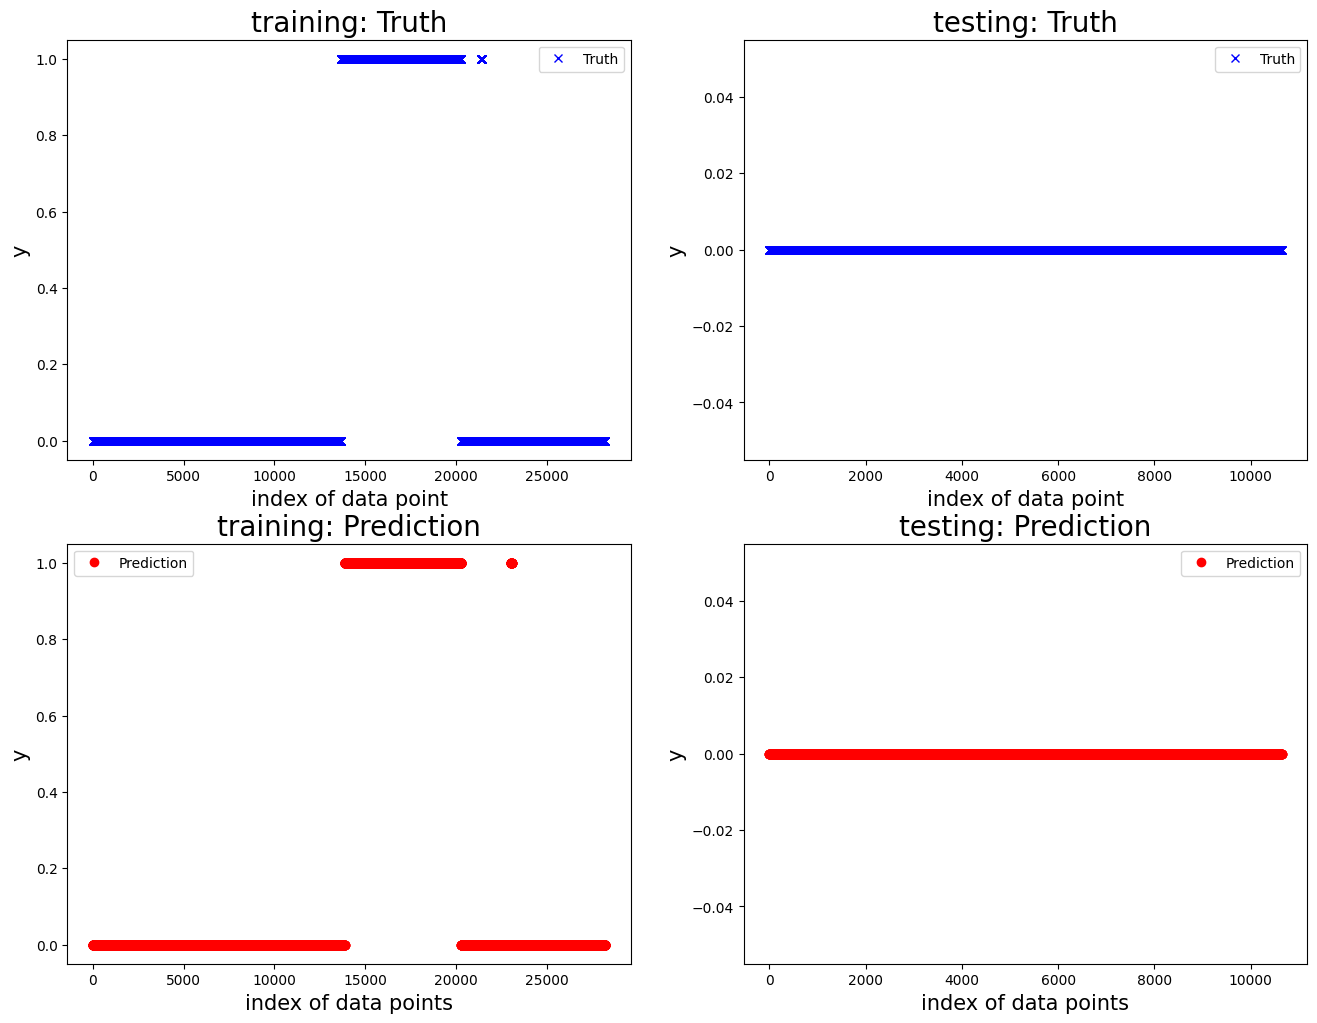


 New run:

training performance, accuracy is: 0.9980613893376413
training performance, precision is: 1.0
training performance, recall: 0.55
training performance, F1: 0.7096774193548387



 New run:

testing performance, accuracy is: 0.6722490395034972
testing performance, precision is: 0.0
testing performance, recall: 0.0
testing performance, F1: 0.0




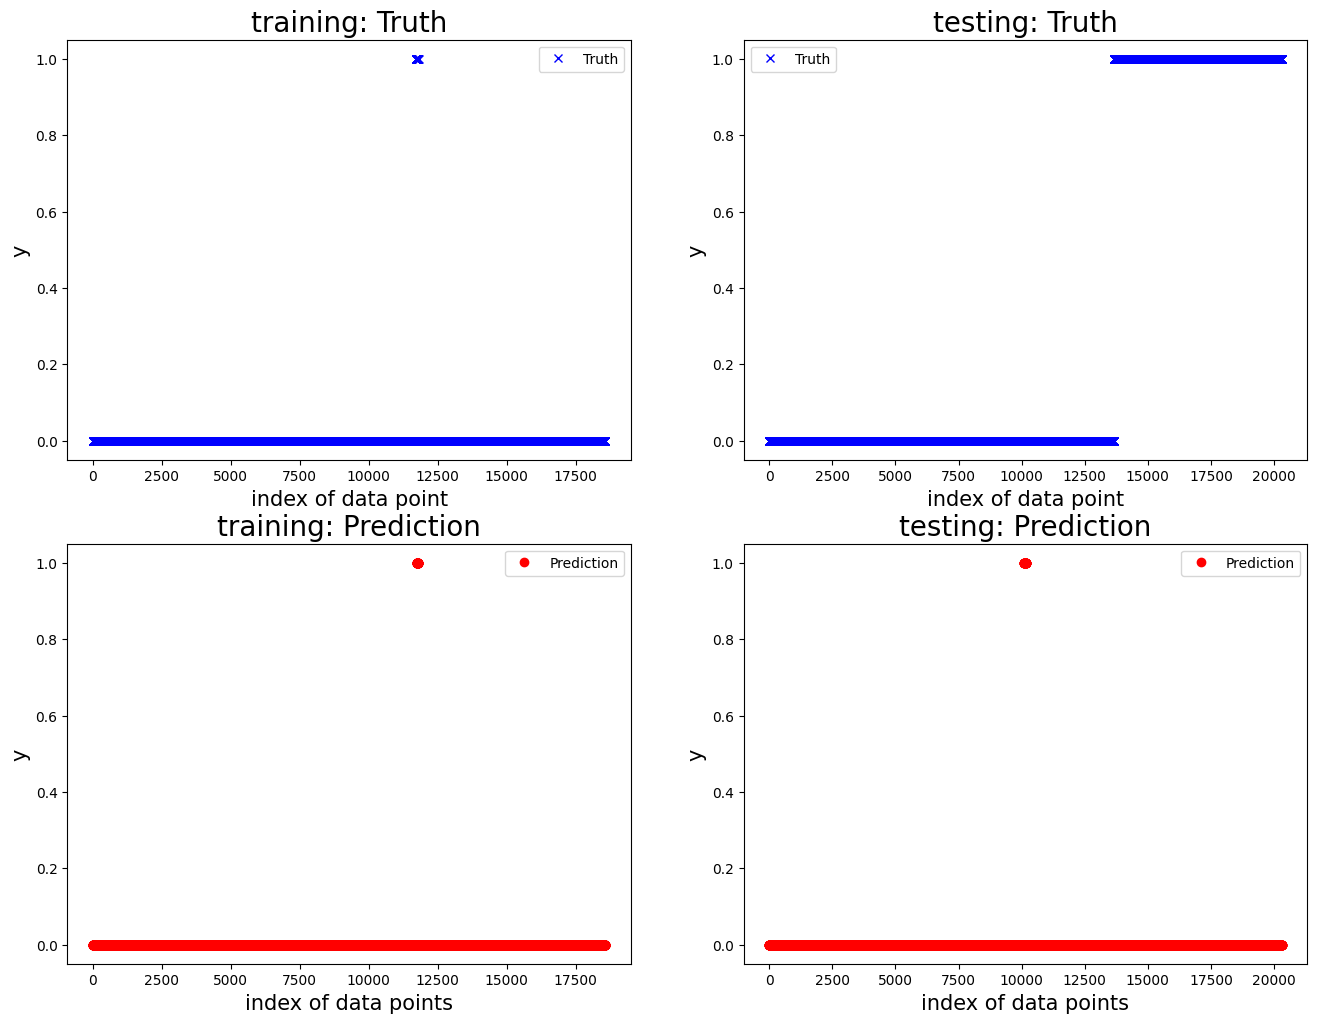


 New run:

training performance, accuracy is: 0.9936239243898999
training performance, precision is: 0.9947490347490348
training performance, recall: 0.9710538218000905
training performance, F1: 0.9827586206896551



 New run:

testing performance, accuracy is: 0.9699445579223811
testing performance, precision is: 0.24444444444444444
testing performance, recall: 0.1375
testing performance, F1: 0.176




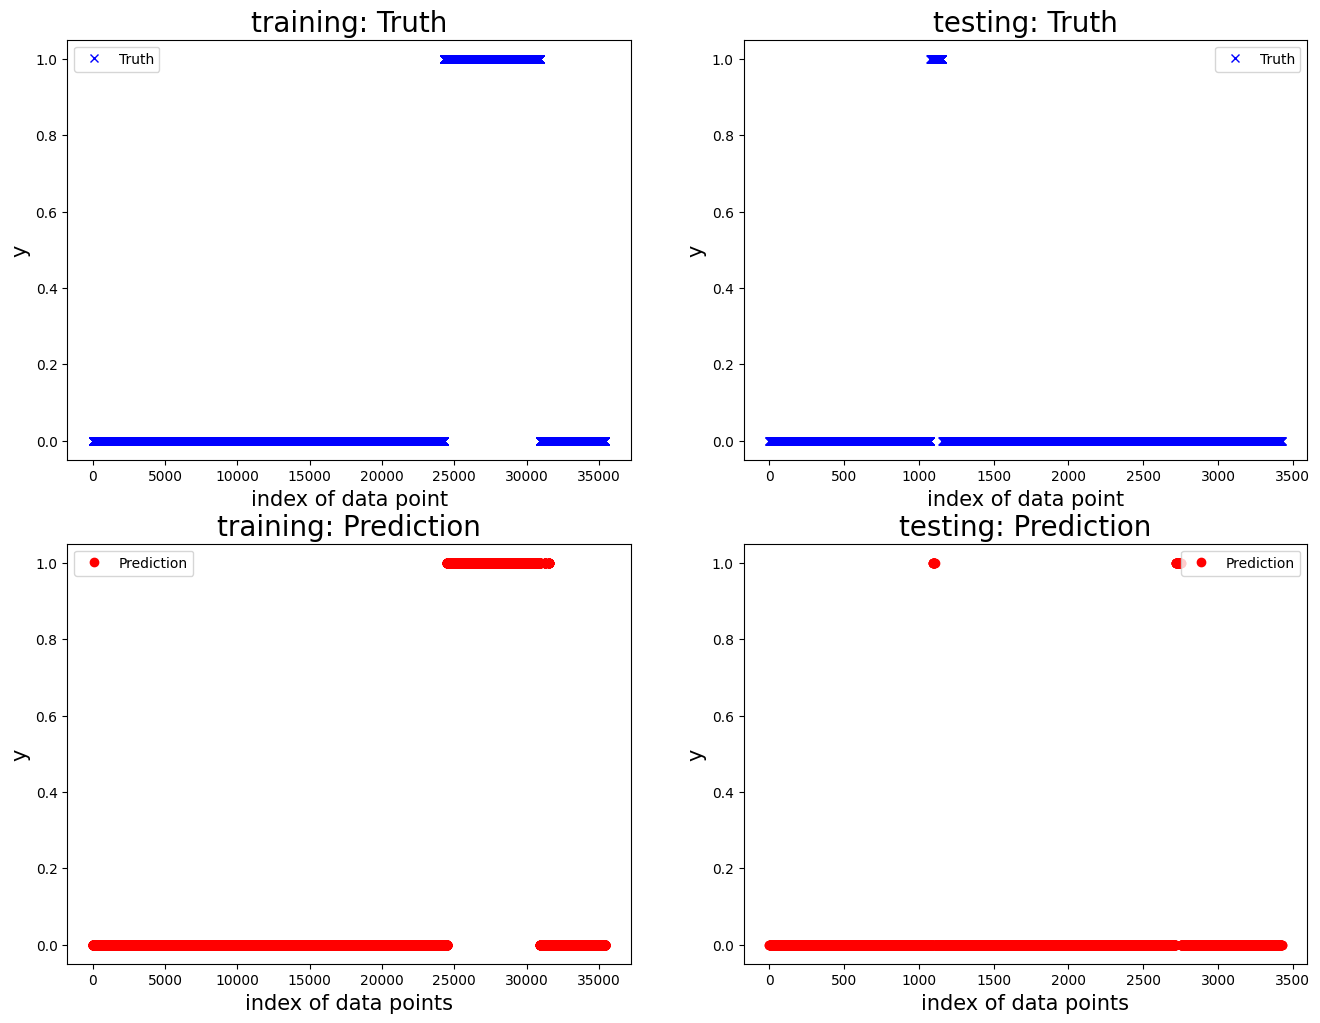


 New run:

training performance, accuracy is: 0.991548927263213
training performance, precision is: 0.9922958397534669
training performance, recall: 0.959332638164755
training performance, F1: 0.9755358630614255



 New run:

testing performance, accuracy is: 0.9049079754601227
testing performance, precision is: 0.0
testing performance, recall: 0.0
testing performance, F1: 0.0




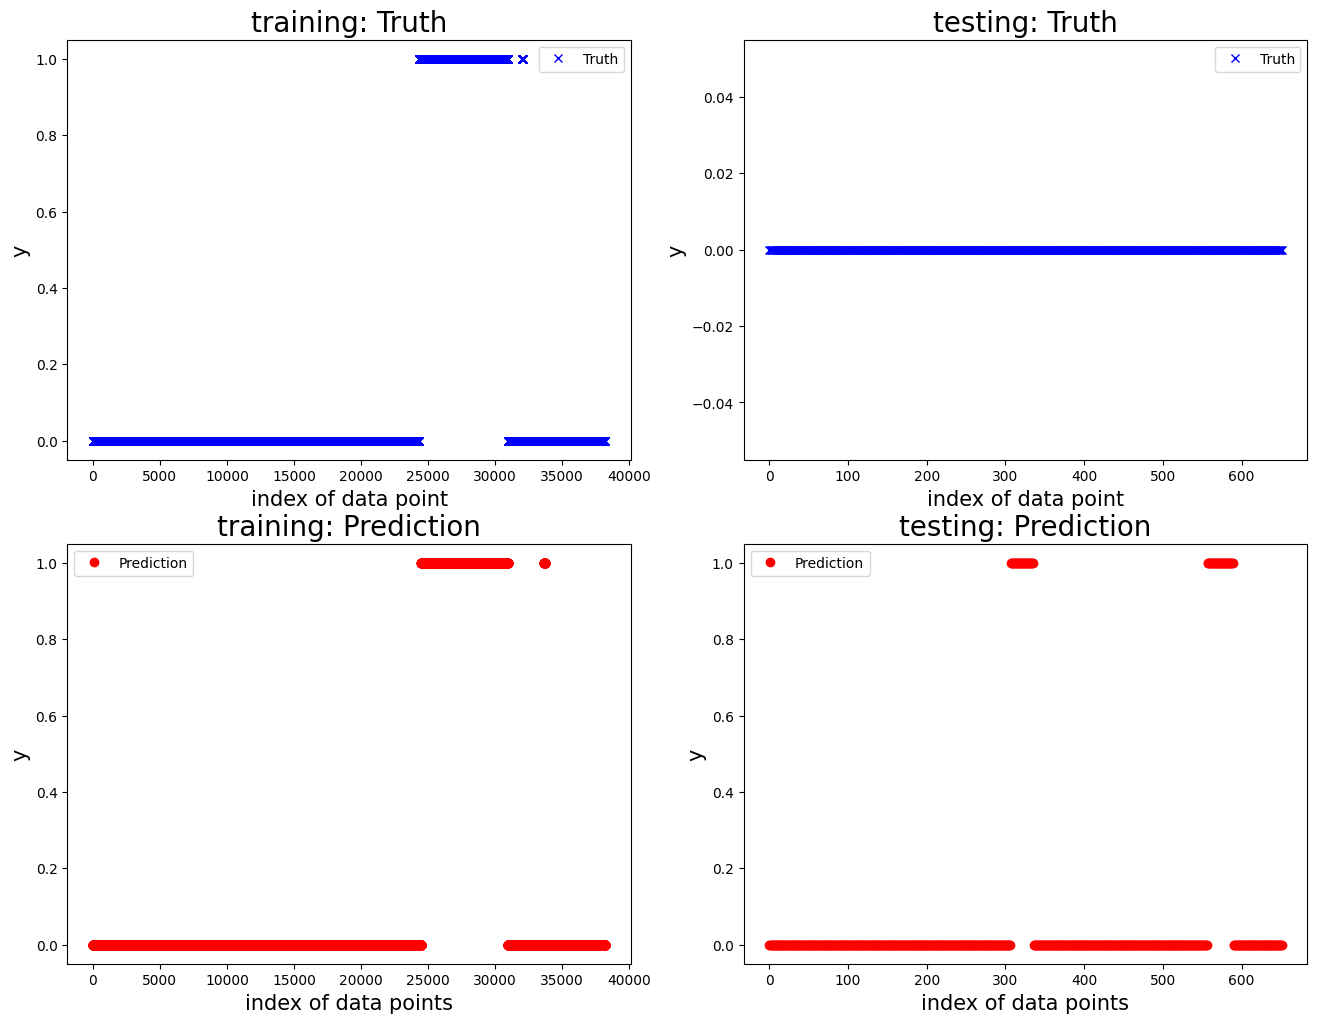


 New run:

training performance, accuracy is: 0.9912631338510736
training performance, precision is: 0.9950548601452635
training performance, recall: 0.9591836734693877
training performance, F1: 0.9767900485436893



 New run:

testing performance, accuracy is: 1.0
testing performance, precision is: 1.0
testing performance, recall: 1.0
testing performance, F1: 1.0




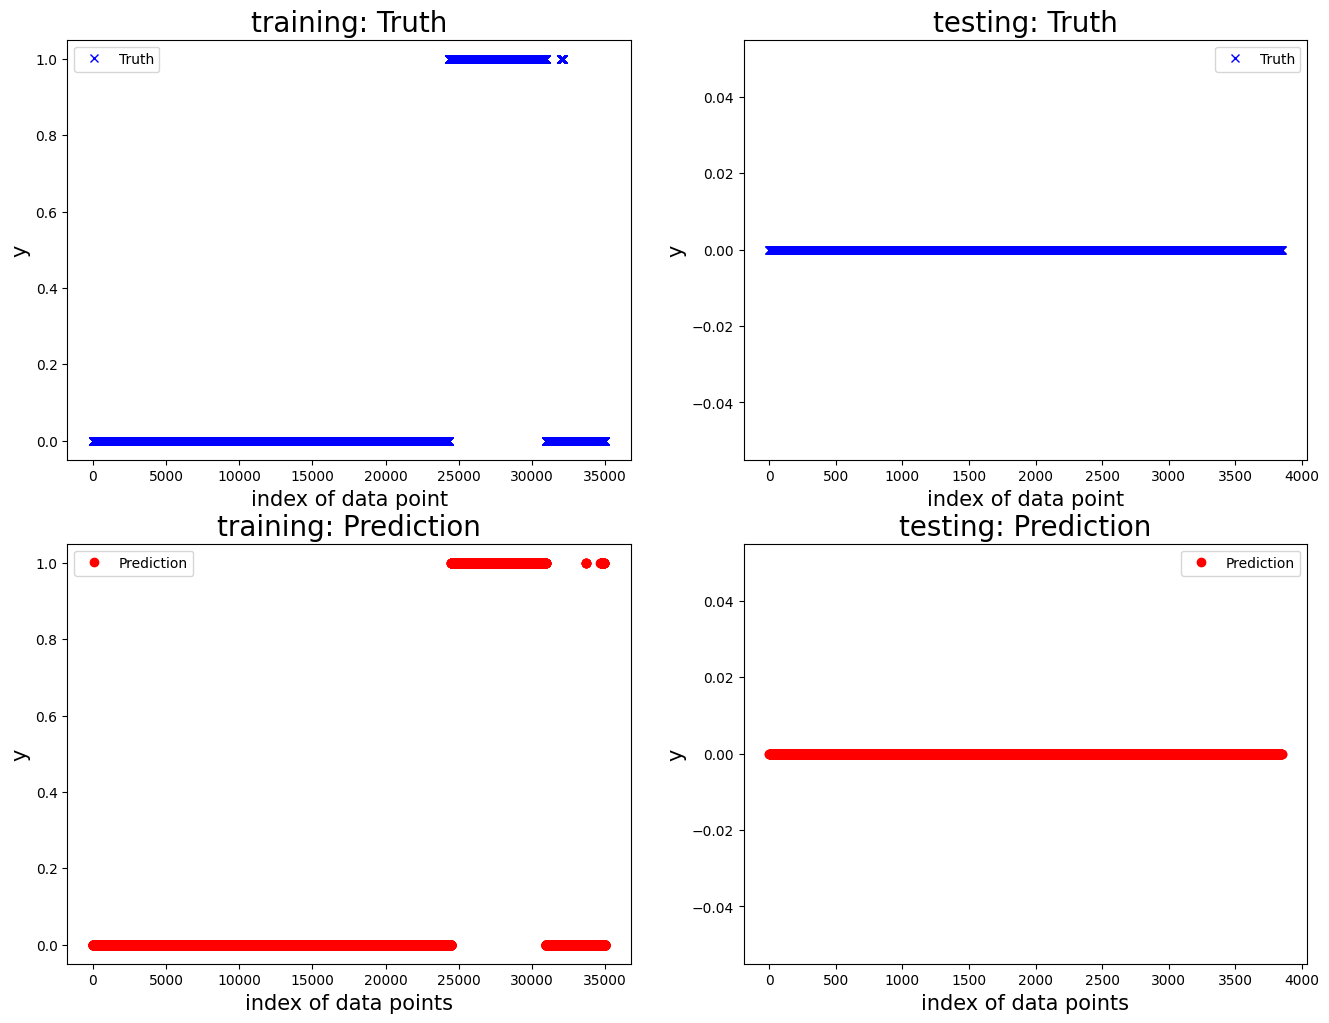

   Accuracy  Precision  Recall  F1 score
0  1.000000   1.000000  1.0000     1.000
1  0.672249   0.000000  0.0000     0.000
2  0.969945   0.244444  0.1375     0.176
3  0.904908   0.000000  0.0000     0.000
4  1.000000   1.000000  1.0000     1.000


Mean performance metric and standard error:
Accuracy: 0.9094 +- 0.1382
Precision: 0.4489 +- 0.5129
Recall: 0.4275 +- 0.5256
F1 score: 0.4352 +- 0.5206




In [31]:
from utility import extract_selected_feature, prepare_sliding_window, run_cv_one_motor

# Define the motor index.
motor_idx = 2

# Specify the test conditions you would like to include in the training.
df_data_experiment = df_train[df_train['test_condition'].isin(not_moving_train + pickup_and_place_train + moving_motor_mixed_train)]

# Define the features.
feature_list_all = ['time', 'data_motor_1_position', 'data_motor_1_temperature', 'data_motor_1_voltage',
                    'data_motor_2_position', 'data_motor_2_temperature', 'data_motor_2_voltage',
                    'data_motor_3_position', 'data_motor_3_temperature', 'data_motor_3_voltage',
                    'data_motor_4_position', 'data_motor_4_temperature', 'data_motor_4_voltage',
                    'data_motor_5_position', 'data_motor_5_temperature', 'data_motor_5_voltage',
                    'data_motor_6_position', 'data_motor_6_temperature', 'data_motor_6_voltage']

feature_list_motor2 = ['data_motor_1_temperature',  
                       'data_motor_2_temperature', 
                       'data_motor_3_position', 'data_motor_3_temperature', 
                       'data_motor_6_temperature']

# Extract the features.
df_tr_x, df_tr_y = extract_selected_feature(df_data_experiment, feature_list_motor2, motor_idx, mdl_type='clf')

# Prepare the training data based on the defined sliding window.
window_size = 20
sample_step = 5
X_train, y_train = prepare_sliding_window(df_x=df_tr_x, y=df_tr_y, window_size=window_size, sample_step=sample_step, mdl_type='clf')

# Define the classification model.
# Define the steps of the pipeline
steps = [
    ('standardizer', StandardScaler()),  # Step 1: StandardScaler
    ('mdl', LogisticRegression() )   # Step 2: Linear Regression
]

# Create the pipeline
model2 = Pipeline(steps)

# # Define hyperparameters to search
# param_grid = {
#     'mdl__C': [0.001, 0.01, 0.1, 1, 10, 100]  # Inverse of regularization strength
# }

# # Initialize GridSearchCV
# grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring='f1', cv=5)
# mdl = grid_search.fit(X_train, y_train)
# best_params = grid_search.best_params_
# print("Best parameters found: ", best_params)


all_result = run_cv_one_motor(single_run_result=True, motor_idx=motor_idx,  window_size=window_size, sample_step=sample_step,
                              df_data=df_data_experiment, mdl=model2, 
                              feature_list=feature_list_motor2, n_fold=5)
# Train the model.
# mdl = grid_search.fit(X_train, y_train)

In [32]:
df_tr_x, df_tr_y = extract_selected_feature(df_data_experiment, feature_list_motor2, motor_idx = 2, mdl_type='clf')

model2.fit(df_tr_x, df_tr_y)
# Get the features.
feature_list_motor2 += ['test_condition']

df_test_x = df_test[feature_list_motor2]
y_pred_2 = model2.predict(df_test_x)

### Prediction.

In this section, put the code of prediction here. In the end, please output a variable `y_pred_6`, containing the results of the prediction on motor 1.

## Prepare the results as a submission file for the data challenge.

In this section, we demo how to prepare the results as a submission file for the data challenge. First, we need to download the submission template `sample_submission.csv` from [kaggle](https://www.kaggle.com/competitions/robot-predictive-maintenance/data). As shown below, in this csv files, we just need to give our prediction on the six motors in the corresponding columns. You can find a demo below.

In [41]:
import pandas as pd

# Read the template.
path = 'dataset/sample_solution.csv' # Change to your path.
df_submission = pd.read_csv(path)

# Initial all values with -1.
df_submission.loc[:, ['data_motor_1_label', 'data_motor_2_label', 'data_motor_3_label', 'data_motor_4_label', 'data_motor_5_label', 'data_motor_6_label']] = -1
df_submission.head()

,idx,data_motor_1_label,data_motor_2_label,data_motor_3_label,data_motor_4_label,data_motor_5_label,data_motor_6_label
0,0,-1,-1,-1,-1,-1,-1
1,1,-1,-1,-1,-1,-1,-1
2,2,-1,-1,-1,-1,-1,-1
3,3,-1,-1,-1,-1,-1,-1
4,4,-1,-1,-1,-1,-1,-1


In [42]:
# Replace each column with your prediction.
df_submission['data_motor_1_label'] = y_pred_1
df_submission['data_motor_2_label'] = y_pred_2
df_submission['data_motor_3_label'] = y_pred_3
df_submission['data_motor_4_label'] = y_pred_4
df_submission['data_motor_5_label'] = y_pred_5
df_submission['data_motor_6_label'] = y_pred_6

# For the other motors, we just fill with 0.
df_submission.loc[:, ['data_motor_6_label']] = 0

In [43]:
# Output the submission csv.
df_submission.to_csv('results/submission1_2.csv')